In [6]:
import sys
sys.path.append('..')

from utils.constants import *
from utils.file_readers import *
from utils.data_exploration import *
from utils.signal_processing import *
from utils.sliding_window import *
from utils.stand_norm import *

import random
import pandas as pd

from sklearn import metrics
import seaborn as sns

In [7]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Conv1D, Dropout, MaxPooling1D, BatchNormalization
from keras import optimizers

Using TensorFlow backend.


In [ ]:
df_all = pd.read_csv('../Preprocessed/all_data.csv')

In [ ]:
activity_label = 0

Create comparative plots across subjects for the signals to gauge how easily differentiable they are.

In [ ]:
subjects = get_subject_names()
correctness = 'correct'

fig = plt.figure(figsize=(20, 40))
fig.subplots_adjust(hspace=1, wspace=0.5)
subject_counter = 0

axes = ['accel_x_normalised', 'accel_y_normalised', 'accel_z_normalised']
axes_counter = 0

for i in range(1, 3*len(subjects) + 1):
    subject = subjects[subject_counter]
    
    mask = (df_all['subject'] == subject) & (df_all['correctness'] == correctness) & (df_all['activity'] == activity_label)
    
    df_filtered = df_all[mask]
    
    ax = fig.add_subplot(len(subjects), 3, i)
    plt.plot(df_filtered[axes[axes_counter]])
    plt.title("S_{}, {}".format(subject_counter, axes[axes_counter]))
    
    ax.set_ylim((0, 1))
    ax.set_xticklabels(range(len(df_filtered[axes[axes_counter]])))
    
    if i%3 == 0:
        subject_counter += 1
    
    if axes_counter == 2:
        axes_counter = 1
    else:
        axes_counter += 1

### LOSOXV for one activity

In [ ]:
def generate_range(n, end, start=0):
    return list(range(start, n)) + list(range(n+1, end))

In [ ]:
data = pd.read_csv("../Preprocessed/raw_data.csv")
data = data.reindex(columns=['timestamp', 'seq', 'accel_x', 'accel_y', 'accel_z',
                             'accel_magnitude', 'accel_pca',
                             'subject', 'activity', 'correctness',
                             'accel_x_standardised', 'accel_y_standardised', 'accel_z_standardised',
                             'accel_magnitude_standardised', 'accel_pca_standardised',
                             'accel_x_normalised', 'accel_y_normalised', 'accel_z_normalised',
                             'accel_magnitude_normalised', 'accel_pca_normalised'])

random.seed(42)

In [ ]:
subjects = get_subject_names()
n_subjects = len(subjects)

n_train_subjects = 12
n_validation_subjects = 2

In [ ]:
activities = 'all'
one_vs_all_activity = 1
correctness = 'correct'

In [ ]:
n_time_steps = 38
step = 19
n_features = 3

In [ ]:
features = ['accel_x_normalised', 'accel_y_normalised', 'accel_z_normalised']

In [ ]:
num_filters = 64
kernel_size = 3
activation = 'relu'

n_classes = 2

In [ ]:
def initialise_model():
    model = Sequential()
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, 
                     activation=activation, input_shape=(n_time_steps, n_features)))
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, 
                     activation=activation))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, 
                     activation=activation))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    model.summary()
    return model

In [ ]:
# optimiser
sgd = optimizers.SGD(lr=0.0001)

# train model
batch_size = 32
epochs = 250

In [ ]:
# dictionaries for statistics
# they will all have keys = left out subject and value = stats 
cm = {}
histories = {}

In [ ]:
# dataframe for statistics
losoxv_stats = pd.DataFrame(index=subjects, columns=['train_acc', 'train_loss',
                                                    'valid_acc', 'valid_loss',
                                                    'test_acc', 'test_loss'])

In [ ]:
save_path = "../Plots/08_Knee_extensions/"

In [ ]:
for i in range(len(subjects)):
    
#     early stopping for testing
#     if i > 1:
#         break
    
    # generate training, validation and test subjects
    
    left_out_subject = subjects[i]
    print("Left out subject = {}".format(subjects[i]))
    
    rng = generate_range(i, n_subjects)
    
    train_subjects = set()
    while(len(train_subjects) < n_train_subjects):
        choice = random.choice(rng)
        train_subjects.add(choice)
    
    # for validation, take the remaining ones
    valid_subjects = [subjects[j] for j in (set(rng) - train_subjects)]
    
    train_subjects = [subjects[j] for j in train_subjects]
    
    print("Test subjects = {}".format(train_subjects))
    print("Validation subjects = {}".format(valid_subjects))
    
    train_valid_subjects = train_subjects + valid_subjects
    
    # split the data
    mask_subj = (data['subject'] == train_valid_subjects[0])
    for tvs in train_valid_subjects:
        mask_subj = mask_subj | (data['subject'] == tvs)
        
    data_train = data[mask_subj]
    data_train.reset_index(drop=True, inplace=True)
    
    data_test = data[data['subject'] == left_out_subject]
    data_test.reset_index(drop=True, inplace=True)
    
    print("-" * 80)
    print("Removing outliers")
    print("-" * 80)
    
    # remove outliers for training
    data_train, _, _ = remove_outliers(data_train, activities=activities, subjects=train_valid_subjects, correctness=correctness)
    
    # remove outliers for test
    data_test, _, _ = remove_outliers(data_test, activities=activities, subjects=[left_out_subject], correctness=correctness)
    
    print("-" * 80)
    print("Standardising")
    print("-" * 80)
    
    # standardise for training
    data_train = standardise_data(data_train, activities=activities, subjects=train_valid_subjects, correctness=correctness)
    
    # standardise for test
    data_test = standardise_data(data_test, activities=activities, subjects=[left_out_subject], correctness=correctness)
    
    print("-" * 80)
    print("Normalising")
    print("-" * 80)
    
    # normalise for training
    data_train, scaler_fit = normalise_data(data_train, activities=activities, subjects=train_valid_subjects, correctness=correctness)
    
    # normalise for test
    data_test, _ = normalise_data(data_test, activities=activities, subjects=[left_out_subject], 
                                  correctness=correctness, scaler_fit=scaler_fit)
    
    print("-" * 80)
    print("Generating datasets")
    print("-" * 80)
    
    # Generate datasets
    X_train, y_train = generate_dataset(df=data_train, n_time_steps=n_time_steps, n_features=n_features,
                                   step=step, features=features,
                                   one_vs_all_activity=one_vs_all_activity, subjects=train_subjects, 
                                        correctness=correctness, downsample_rate=10)
    
    print("Training set shapes: X_train = {}, y_train = {}".format(X_train.shape, y_train.shape))
    
    X_valid, y_valid = generate_dataset(df=data_train, n_time_steps=n_time_steps, n_features=n_features,
                                   step=step, features=features,
                                   one_vs_all_activity=one_vs_all_activity, subjects=valid_subjects, 
                                        correctness=correctness, downsample_rate=10)
    
    print("Valid set shapes: X_valid = {}, y_valid = {}".format(X_valid.shape, y_valid.shape))
    
    X_test, y_test = generate_dataset(df=data_test, n_time_steps=n_time_steps, n_features=n_features,
                                   step=step, features=features,
                                   one_vs_all_activity=one_vs_all_activity, subjects=[left_out_subject], 
                                      correctness=correctness, downsample_rate=10)
    
    print("Test set shapes: X_test = {}, y_test = {}".format(X_test.shape, y_test.shape))
    
    # create new model
    model = initialise_model()

    # compile model
    model.compile(optimizer=sgd,
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'mse'])

    history = model.fit(X_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       validation_data=(X_valid, y_valid))
    
    # stats
    y_pred_ohe = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred_ohe, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    activity_labels = get_activity_label_dict()
    cm_labels = [activity_labels[one_vs_all_activity], "Not {}".format(activity_labels[one_vs_all_activity])]

    confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
    fig = plt.figure(figsize=(10, 6))
    ax = sns.heatmap(confusion_matrix, xticklabels=cm_labels, yticklabels=cm_labels, annot=True, fmt='d')
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True labels", fontsize=14)
    plt.title("CM - LOS = {}".format(left_out_subject))
    fig.tight_layout()
    plt.savefig(save_path + "{}_CM_LOS.pdf".format(left_out_subject))
    
    fig = plt.figure(figsize=(10,6))
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.title("Learning curve - LOS = {}".format(left_out_subject))
    plt.legend(fontsize=12)
    fig.tight_layout()
    plt.savefig(save_path + "{}_LC_LOS.pdf".format(left_out_subject))
    
    # record stats
    losoxv_stats.loc[left_out_subject, 'train_acc'] = history.history['accuracy'][-1]
    losoxv_stats.loc[left_out_subject, 'train_loss'] = history.history['loss'][-1]
    losoxv_stats.loc[left_out_subject, 'valid_acc'] = history.history['val_accuracy'][-1]
    losoxv_stats.loc[left_out_subject, 'valid_loss'] = history.history['val_loss'][-1]
    
    final_loss, final_acc, final_mse = model.evaluate(X_test, y_test, batch_size)
    print("Final loss = {}".format(final_loss))
    print("Final accuracy = {}".format(final_acc))
    
    losoxv_stats.loc[left_out_subject, 'test_acc'] = final_acc
    losoxv_stats.loc[left_out_subject, 'test_loss'] = final_loss
    
    # update cm and history
    cm[left_out_subject] = confusion_matrix
    histories[left_out_subject] = history

### Using the function

In [8]:
from utils.one_vs_all_training import *

In [9]:
activity_names = get_activity_name_dict()
one_vs_all_activity = activity_names['Knee extension']

In [10]:
experiment_name = "08_Knee_extensions_downsampled_16_balance_40"

In [11]:
os.mkdir("../Plots/{}".format(experiment_name))
if not os.path.exists("../Plots/{}".format(experiment_name)):
    os.mkdir("../Plots/{}".format(experiment_name))

In [12]:
random_seed = 42
correctness = 'correct'

n_train_subjects = 12
n_validation_subjects = 2

n_time_steps = 38
step = 19
n_features = 3

features = ['accel_x_normalised', 'accel_y_normalised', 'accel_z_normalised']

num_filters = 64
kernel_size = 3
activation = 'relu'
lr = 0.0001
batch_size = 32

epochs = 200

downsample_rate = 16
positive_class_weight = 40.

Left out subject = adela
Test subjects = ['aggie', 'andrius', 'diana', 'jack', 'joao', 'nikita', 'rim', 'ron', 'santi', 'seb', 'sharan', 'teo']
Validation subjects = ['lukasz', 'zoe']
--------------------------------------------------------------------------------
Removing outliers
--------------------------------------------------------------------------------
Original dataframe length = 117502
New dataframe length = 116737
Removed 765 outliers
Original dataframe length = 8965
New dataframe length = 8895
Removed 70 outliers
--------------------------------------------------------------------------------
Standardising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Normalising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Generating datasets
------------------

1876/1876 [==============================] - 2s 856us/step - loss: 0.5744 - accuracy: 0.8502 - mse: 0.1128 - val_loss: 0.3347 - val_accuracy: 0.8547 - val_mse: 0.1053
Epoch 32/200
1876/1876 [==============================] - 2s 832us/step - loss: 0.5542 - accuracy: 0.8523 - mse: 0.1077 - val_loss: 0.3329 - val_accuracy: 0.8547 - val_mse: 0.1047
Epoch 33/200
1876/1876 [==============================] - 2s 826us/step - loss: 0.5571 - accuracy: 0.8534 - mse: 0.1086 - val_loss: 0.3319 - val_accuracy: 0.8547 - val_mse: 0.1045
Epoch 34/200
1876/1876 [==============================] - 2s 832us/step - loss: 0.5531 - accuracy: 0.8561 - mse: 0.1073 - val_loss: 0.3331 - val_accuracy: 0.8547 - val_mse: 0.1051
Epoch 35/200
1876/1876 [==============================] - 2s 822us/step - loss: 0.5437 - accuracy: 0.8571 - mse: 0.1060 - val_loss: 0.3256 - val_accuracy: 0.8615 - val_mse: 0.1027
Epoch 36/200
1876/1876 [==============================] - 2s 845us/step - loss: 0.5388 - accuracy: 0.8518 - mse: 

1876/1876 [==============================] - 2s 816us/step - loss: 0.4468 - accuracy: 0.8779 - mse: 0.0892 - val_loss: 0.2874 - val_accuracy: 0.8716 - val_mse: 0.0928
Epoch 77/200
1876/1876 [==============================] - 1s 792us/step - loss: 0.4341 - accuracy: 0.8763 - mse: 0.0878 - val_loss: 0.2864 - val_accuracy: 0.8716 - val_mse: 0.0925
Epoch 78/200
1876/1876 [==============================] - 2s 816us/step - loss: 0.4250 - accuracy: 0.8833 - mse: 0.0851 - val_loss: 0.2896 - val_accuracy: 0.8716 - val_mse: 0.0935
Epoch 79/200
1876/1876 [==============================] - 2s 816us/step - loss: 0.4282 - accuracy: 0.8785 - mse: 0.0875 - val_loss: 0.2833 - val_accuracy: 0.8716 - val_mse: 0.0917
Epoch 80/200
1876/1876 [==============================] - 2s 815us/step - loss: 0.4160 - accuracy: 0.8774 - mse: 0.0873 - val_loss: 0.2752 - val_accuracy: 0.8716 - val_mse: 0.0893
Epoch 81/200
1876/1876 [==============================] - 2s 803us/step - loss: 0.4232 - accuracy: 0.8822 - mse: 

1876/1876 [==============================] - 2s 800us/step - loss: 0.3794 - accuracy: 0.8891 - mse: 0.0776 - val_loss: 0.2536 - val_accuracy: 0.8851 - val_mse: 0.0835
Epoch 122/200
1876/1876 [==============================] - 1s 786us/step - loss: 0.3731 - accuracy: 0.8907 - mse: 0.0760 - val_loss: 0.2560 - val_accuracy: 0.8784 - val_mse: 0.0842
Epoch 123/200
1876/1876 [==============================] - 1s 780us/step - loss: 0.3732 - accuracy: 0.8918 - mse: 0.0762 - val_loss: 0.2533 - val_accuracy: 0.8818 - val_mse: 0.0834
Epoch 124/200
1876/1876 [==============================] - 1s 784us/step - loss: 0.3843 - accuracy: 0.8897 - mse: 0.0766 - val_loss: 0.2623 - val_accuracy: 0.8784 - val_mse: 0.0861
Epoch 125/200
1876/1876 [==============================] - 1s 782us/step - loss: 0.3650 - accuracy: 0.8881 - mse: 0.0783 - val_loss: 0.2473 - val_accuracy: 0.8885 - val_mse: 0.0817
Epoch 126/200
1876/1876 [==============================] - 1s 794us/step - loss: 0.3751 - accuracy: 0.8897 - 

1876/1876 [==============================] - 1s 773us/step - loss: 0.3473 - accuracy: 0.8993 - mse: 0.0722 - val_loss: 0.2332 - val_accuracy: 0.8919 - val_mse: 0.0779
Epoch 167/200
1876/1876 [==============================] - 1s 765us/step - loss: 0.3492 - accuracy: 0.8998 - mse: 0.0710 - val_loss: 0.2383 - val_accuracy: 0.8885 - val_mse: 0.0793
Epoch 168/200
1876/1876 [==============================] - 1s 767us/step - loss: 0.3379 - accuracy: 0.8993 - mse: 0.0705 - val_loss: 0.2438 - val_accuracy: 0.8885 - val_mse: 0.0808
Epoch 169/200
1876/1876 [==============================] - 1s 784us/step - loss: 0.3389 - accuracy: 0.8998 - mse: 0.0696 - val_loss: 0.2366 - val_accuracy: 0.8885 - val_mse: 0.0788
Epoch 170/200
1876/1876 [==============================] - 1s 764us/step - loss: 0.3485 - accuracy: 0.8966 - mse: 0.0701 - val_loss: 0.2504 - val_accuracy: 0.8851 - val_mse: 0.0829
Epoch 171/200
1876/1876 [==============================] - 1s 785us/step - loss: 0.3436 - accuracy: 0.8987 - 

Train on 1821 samples, validate on 384 samples
Epoch 1/200
1821/1821 [==============================] - 4s 2ms/step - loss: 2.3201 - accuracy: 0.2444 - mse: 0.3433 - val_loss: 0.6888 - val_accuracy: 0.6458 - val_mse: 0.2478
Epoch 2/200
1821/1821 [==============================] - 1s 756us/step - loss: 2.1144 - accuracy: 0.1971 - mse: 0.3621 - val_loss: 0.7002 - val_accuracy: 0.3438 - val_mse: 0.2535
Epoch 3/200
1821/1821 [==============================] - 1s 738us/step - loss: 1.9882 - accuracy: 0.1686 - mse: 0.3794 - val_loss: 0.7073 - val_accuracy: 0.2552 - val_mse: 0.2571
Epoch 4/200
1821/1821 [==============================] - 1s 758us/step - loss: 1.8694 - accuracy: 0.1631 - mse: 0.3785 - val_loss: 0.7118 - val_accuracy: 0.2422 - val_mse: 0.2593
Epoch 5/200
1821/1821 [==============================] - 1s 760us/step - loss: 1.7674 - accuracy: 0.2021 - mse: 0.3606 - val_loss: 0.7165 - val_accuracy: 0.2214 - val_mse: 0.2617
Epoch 6/200
1821/1821 [==============================] - 1s 

1821/1821 [==============================] - 1s 753us/step - loss: 0.6965 - accuracy: 0.8193 - mse: 0.1375 - val_loss: 0.3863 - val_accuracy: 0.8255 - val_mse: 0.1262
Epoch 47/200
1821/1821 [==============================] - 1s 756us/step - loss: 0.6843 - accuracy: 0.8221 - mse: 0.1374 - val_loss: 0.3780 - val_accuracy: 0.8281 - val_mse: 0.1234
Epoch 48/200
1821/1821 [==============================] - 1s 735us/step - loss: 0.6820 - accuracy: 0.8281 - mse: 0.1303 - val_loss: 0.3783 - val_accuracy: 0.8307 - val_mse: 0.1235
Epoch 49/200
1821/1821 [==============================] - 1s 767us/step - loss: 0.6672 - accuracy: 0.8320 - mse: 0.1313 - val_loss: 0.3742 - val_accuracy: 0.8333 - val_mse: 0.1220
Epoch 50/200
1821/1821 [==============================] - 1s 764us/step - loss: 0.6657 - accuracy: 0.8309 - mse: 0.1293 - val_loss: 0.3732 - val_accuracy: 0.8359 - val_mse: 0.1216
Epoch 51/200
1821/1821 [==============================] - 1s 756us/step - loss: 0.6565 - accuracy: 0.8287 - mse: 

1821/1821 [==============================] - 1s 755us/step - loss: 0.5252 - accuracy: 0.8600 - mse: 0.1037 - val_loss: 0.3167 - val_accuracy: 0.8516 - val_mse: 0.1027
Epoch 92/200
1821/1821 [==============================] - 1s 773us/step - loss: 0.5227 - accuracy: 0.8666 - mse: 0.1029 - val_loss: 0.3173 - val_accuracy: 0.8516 - val_mse: 0.1028
Epoch 93/200
1821/1821 [==============================] - 1s 765us/step - loss: 0.5251 - accuracy: 0.8622 - mse: 0.1033 - val_loss: 0.3191 - val_accuracy: 0.8542 - val_mse: 0.1034
Epoch 94/200
1821/1821 [==============================] - 1s 737us/step - loss: 0.5155 - accuracy: 0.8644 - mse: 0.1031 - val_loss: 0.3107 - val_accuracy: 0.8568 - val_mse: 0.1008
Epoch 95/200
1821/1821 [==============================] - 1s 776us/step - loss: 0.5237 - accuracy: 0.8616 - mse: 0.1012 - val_loss: 0.3095 - val_accuracy: 0.8568 - val_mse: 0.1004
Epoch 96/200
1821/1821 [==============================] - 1s 765us/step - loss: 0.5215 - accuracy: 0.8715 - mse: 

1821/1821 [==============================] - 1s 772us/step - loss: 0.4487 - accuracy: 0.8759 - mse: 0.0902 - val_loss: 0.2816 - val_accuracy: 0.8698 - val_mse: 0.0913
Epoch 137/200
1821/1821 [==============================] - 1s 748us/step - loss: 0.4511 - accuracy: 0.8775 - mse: 0.0889 - val_loss: 0.2830 - val_accuracy: 0.8698 - val_mse: 0.0917
Epoch 138/200
1821/1821 [==============================] - 1s 754us/step - loss: 0.4496 - accuracy: 0.8786 - mse: 0.0902 - val_loss: 0.2815 - val_accuracy: 0.8698 - val_mse: 0.0913
Epoch 139/200
1821/1821 [==============================] - 1s 754us/step - loss: 0.4544 - accuracy: 0.8792 - mse: 0.0884 - val_loss: 0.2783 - val_accuracy: 0.8698 - val_mse: 0.0902
Epoch 140/200
1821/1821 [==============================] - 1s 794us/step - loss: 0.4309 - accuracy: 0.8759 - mse: 0.0875 - val_loss: 0.2709 - val_accuracy: 0.8698 - val_mse: 0.0880
Epoch 141/200
1821/1821 [==============================] - 1s 781us/step - loss: 0.4496 - accuracy: 0.8825 - 

1821/1821 [==============================] - 1s 768us/step - loss: 0.3992 - accuracy: 0.8896 - mse: 0.0779 - val_loss: 0.2487 - val_accuracy: 0.8776 - val_mse: 0.0806
Epoch 182/200
1821/1821 [==============================] - 1s 758us/step - loss: 0.3816 - accuracy: 0.8935 - mse: 0.0777 - val_loss: 0.2471 - val_accuracy: 0.8802 - val_mse: 0.0801
Epoch 183/200
1821/1821 [==============================] - 1s 790us/step - loss: 0.3825 - accuracy: 0.8907 - mse: 0.0761 - val_loss: 0.2469 - val_accuracy: 0.8828 - val_mse: 0.0800
Epoch 184/200
1821/1821 [==============================] - 1s 765us/step - loss: 0.3924 - accuracy: 0.8924 - mse: 0.0754 - val_loss: 0.2468 - val_accuracy: 0.8802 - val_mse: 0.0800
Epoch 185/200
1821/1821 [==============================] - 1s 787us/step - loss: 0.3886 - accuracy: 0.8913 - mse: 0.0774 - val_loss: 0.2507 - val_accuracy: 0.8776 - val_mse: 0.0813
Epoch 186/200
1821/1821 [==============================] - 1s 776us/step - loss: 0.3878 - accuracy: 0.8957 - 

1872/1872 [==============================] - 1s 773us/step - loss: 0.9473 - accuracy: 0.6389 - mse: 0.2118 - val_loss: 0.5480 - val_accuracy: 0.7677 - val_mse: 0.1820
Epoch 11/200
1872/1872 [==============================] - 1s 787us/step - loss: 0.8843 - accuracy: 0.6832 - mse: 0.1954 - val_loss: 0.5115 - val_accuracy: 0.7811 - val_mse: 0.1664
Epoch 12/200
1872/1872 [==============================] - 1s 721us/step - loss: 0.8380 - accuracy: 0.7051 - mse: 0.1837 - val_loss: 0.4773 - val_accuracy: 0.8182 - val_mse: 0.1522
Epoch 13/200
1872/1872 [==============================] - 1s 764us/step - loss: 0.7903 - accuracy: 0.7329 - mse: 0.1728 - val_loss: 0.4501 - val_accuracy: 0.8249 - val_mse: 0.1412
Epoch 14/200
1872/1872 [==============================] - 2s 897us/step - loss: 0.7534 - accuracy: 0.7569 - mse: 0.1607 - val_loss: 0.4303 - val_accuracy: 0.8316 - val_mse: 0.1334
Epoch 15/200
1872/1872 [==============================] - 3s 2ms/step - loss: 0.7189 - accuracy: 0.7719 - mse: 0.

Epoch 56/200
1872/1872 [==============================] - 2s 807us/step - loss: 0.3399 - accuracy: 0.9081 - mse: 0.0666 - val_loss: 0.2503 - val_accuracy: 0.8990 - val_mse: 0.0697
Epoch 57/200
1872/1872 [==============================] - 2s 1ms/step - loss: 0.3402 - accuracy: 0.9103 - mse: 0.0666 - val_loss: 0.2488 - val_accuracy: 0.9024 - val_mse: 0.0693
Epoch 58/200
1872/1872 [==============================] - 2s 888us/step - loss: 0.3423 - accuracy: 0.9071 - mse: 0.0667 - val_loss: 0.2466 - val_accuracy: 0.9024 - val_mse: 0.0687
Epoch 59/200
1872/1872 [==============================] - 1s 753us/step - loss: 0.3405 - accuracy: 0.9081 - mse: 0.0671 - val_loss: 0.2441 - val_accuracy: 0.9024 - val_mse: 0.0679
Epoch 60/200
1872/1872 [==============================] - 1s 762us/step - loss: 0.3350 - accuracy: 0.9092 - mse: 0.0656 - val_loss: 0.2440 - val_accuracy: 0.9024 - val_mse: 0.0678
Epoch 61/200
1872/1872 [==============================] - 1s 737us/step - loss: 0.3321 - accuracy: 0.9

1872/1872 [==============================] - 1s 756us/step - loss: 0.2890 - accuracy: 0.9209 - mse: 0.0548 - val_loss: 0.2244 - val_accuracy: 0.9091 - val_mse: 0.0611
Epoch 102/200
1872/1872 [==============================] - 1s 768us/step - loss: 0.2635 - accuracy: 0.9290 - mse: 0.0527 - val_loss: 0.2233 - val_accuracy: 0.9091 - val_mse: 0.0607
Epoch 103/200
1872/1872 [==============================] - 1s 740us/step - loss: 0.2736 - accuracy: 0.9247 - mse: 0.0531 - val_loss: 0.2202 - val_accuracy: 0.9158 - val_mse: 0.0598
Epoch 104/200
1872/1872 [==============================] - 1s 761us/step - loss: 0.2704 - accuracy: 0.9263 - mse: 0.0522 - val_loss: 0.2229 - val_accuracy: 0.9091 - val_mse: 0.0606
Epoch 105/200
1872/1872 [==============================] - 1s 744us/step - loss: 0.2703 - accuracy: 0.9279 - mse: 0.0513 - val_loss: 0.2250 - val_accuracy: 0.9091 - val_mse: 0.0612
Epoch 106/200
1872/1872 [==============================] - 1s 741us/step - loss: 0.2665 - accuracy: 0.9274 - 

1872/1872 [==============================] - 1s 741us/step - loss: 0.2246 - accuracy: 0.9338 - mse: 0.0463 - val_loss: 0.2089 - val_accuracy: 0.9259 - val_mse: 0.0553
Epoch 147/200
1872/1872 [==============================] - 1s 734us/step - loss: 0.2284 - accuracy: 0.9332 - mse: 0.0441 - val_loss: 0.2124 - val_accuracy: 0.9259 - val_mse: 0.0563
Epoch 148/200
1872/1872 [==============================] - 1s 754us/step - loss: 0.2318 - accuracy: 0.9370 - mse: 0.0459 - val_loss: 0.2121 - val_accuracy: 0.9259 - val_mse: 0.0561
Epoch 149/200
1872/1872 [==============================] - 1s 742us/step - loss: 0.2377 - accuracy: 0.9343 - mse: 0.0458 - val_loss: 0.2142 - val_accuracy: 0.9259 - val_mse: 0.0567
Epoch 150/200
1872/1872 [==============================] - 1s 781us/step - loss: 0.2280 - accuracy: 0.9359 - mse: 0.0453 - val_loss: 0.2132 - val_accuracy: 0.9259 - val_mse: 0.0564
Epoch 151/200
1872/1872 [==============================] - 2s 829us/step - loss: 0.2286 - accuracy: 0.9338 - 

1872/1872 [==============================] - 1s 745us/step - loss: 0.1991 - accuracy: 0.9460 - mse: 0.0394 - val_loss: 0.2027 - val_accuracy: 0.9293 - val_mse: 0.0520
Epoch 192/200
1872/1872 [==============================] - 1s 745us/step - loss: 0.2099 - accuracy: 0.9444 - mse: 0.0391 - val_loss: 0.2057 - val_accuracy: 0.9293 - val_mse: 0.0528
Epoch 193/200
1872/1872 [==============================] - 1s 741us/step - loss: 0.1969 - accuracy: 0.9428 - mse: 0.0391 - val_loss: 0.2055 - val_accuracy: 0.9293 - val_mse: 0.0527
Epoch 194/200
1872/1872 [==============================] - 1s 740us/step - loss: 0.2087 - accuracy: 0.9444 - mse: 0.0397 - val_loss: 0.2049 - val_accuracy: 0.9293 - val_mse: 0.0526
Epoch 195/200
1872/1872 [==============================] - 1s 774us/step - loss: 0.2129 - accuracy: 0.9402 - mse: 0.0401 - val_loss: 0.2082 - val_accuracy: 0.9293 - val_mse: 0.0535
Epoch 196/200
1872/1872 [==============================] - 1s 743us/step - loss: 0.2024 - accuracy: 0.9396 - 

1832/1832 [==============================] - 1s 752us/step - loss: 1.3185 - accuracy: 0.5590 - mse: 0.2666 - val_loss: 0.6704 - val_accuracy: 0.6509 - val_mse: 0.2334
Epoch 21/200
1832/1832 [==============================] - 1s 750us/step - loss: 1.2980 - accuracy: 0.5939 - mse: 0.2544 - val_loss: 0.6524 - val_accuracy: 0.6730 - val_mse: 0.2249
Epoch 22/200
1832/1832 [==============================] - 1s 741us/step - loss: 1.2697 - accuracy: 0.6119 - mse: 0.2494 - val_loss: 0.6495 - val_accuracy: 0.6792 - val_mse: 0.2228
Epoch 23/200
1832/1832 [==============================] - 1s 751us/step - loss: 1.2394 - accuracy: 0.6277 - mse: 0.2437 - val_loss: 0.6381 - val_accuracy: 0.6918 - val_mse: 0.2174
Epoch 24/200
1832/1832 [==============================] - 1s 762us/step - loss: 1.2104 - accuracy: 0.6408 - mse: 0.2381 - val_loss: 0.6211 - val_accuracy: 0.7138 - val_mse: 0.2096
Epoch 25/200
1832/1832 [==============================] - 1s 739us/step - loss: 1.1892 - accuracy: 0.6561 - mse: 

1832/1832 [==============================] - 1s 748us/step - loss: 0.8460 - accuracy: 0.8133 - mse: 0.1607 - val_loss: 0.5642 - val_accuracy: 0.8082 - val_mse: 0.1699
Epoch 66/200
1832/1832 [==============================] - 1s 740us/step - loss: 0.8403 - accuracy: 0.8111 - mse: 0.1589 - val_loss: 0.5646 - val_accuracy: 0.8050 - val_mse: 0.1698
Epoch 67/200
1832/1832 [==============================] - 1s 764us/step - loss: 0.8368 - accuracy: 0.8139 - mse: 0.1586 - val_loss: 0.5614 - val_accuracy: 0.8082 - val_mse: 0.1688
Epoch 68/200
1832/1832 [==============================] - 1s 799us/step - loss: 0.8247 - accuracy: 0.8155 - mse: 0.1566 - val_loss: 0.5638 - val_accuracy: 0.8050 - val_mse: 0.1692
Epoch 69/200
1832/1832 [==============================] - 1s 755us/step - loss: 0.8280 - accuracy: 0.8188 - mse: 0.1556 - val_loss: 0.5619 - val_accuracy: 0.8113 - val_mse: 0.1686
Epoch 70/200
1832/1832 [==============================] - 1s 747us/step - loss: 0.8361 - accuracy: 0.8090 - mse: 

1832/1832 [==============================] - 1s 743us/step - loss: 0.7025 - accuracy: 0.8352 - mse: 0.1378 - val_loss: 0.5057 - val_accuracy: 0.8113 - val_mse: 0.1521
Epoch 111/200
1832/1832 [==============================] - 1s 774us/step - loss: 0.6889 - accuracy: 0.8352 - mse: 0.1334 - val_loss: 0.5095 - val_accuracy: 0.8113 - val_mse: 0.1532
Epoch 112/200
1832/1832 [==============================] - 1s 752us/step - loss: 0.6968 - accuracy: 0.8357 - mse: 0.1330 - val_loss: 0.5171 - val_accuracy: 0.8113 - val_mse: 0.1551
Epoch 113/200
1832/1832 [==============================] - 1s 744us/step - loss: 0.6735 - accuracy: 0.8352 - mse: 0.1334 - val_loss: 0.4947 - val_accuracy: 0.8082 - val_mse: 0.1490
Epoch 114/200
1832/1832 [==============================] - 1s 748us/step - loss: 0.6849 - accuracy: 0.8379 - mse: 0.1301 - val_loss: 0.5018 - val_accuracy: 0.8113 - val_mse: 0.1509
Epoch 115/200
1832/1832 [==============================] - 1s 751us/step - loss: 0.6822 - accuracy: 0.8406 - 

1832/1832 [==============================] - 1s 769us/step - loss: 0.5952 - accuracy: 0.8455 - mse: 0.1160 - val_loss: 0.4608 - val_accuracy: 0.8082 - val_mse: 0.1396
Epoch 156/200
1832/1832 [==============================] - 1s 740us/step - loss: 0.5856 - accuracy: 0.8461 - mse: 0.1161 - val_loss: 0.4560 - val_accuracy: 0.8082 - val_mse: 0.1382
Epoch 157/200
1832/1832 [==============================] - 1s 742us/step - loss: 0.5881 - accuracy: 0.8477 - mse: 0.1140 - val_loss: 0.4575 - val_accuracy: 0.8082 - val_mse: 0.1387
Epoch 158/200
1832/1832 [==============================] - 1s 742us/step - loss: 0.5888 - accuracy: 0.8439 - mse: 0.1153 - val_loss: 0.4588 - val_accuracy: 0.8082 - val_mse: 0.1389
Epoch 159/200
1832/1832 [==============================] - 2s 892us/step - loss: 0.5736 - accuracy: 0.8472 - mse: 0.1144 - val_loss: 0.4486 - val_accuracy: 0.8082 - val_mse: 0.1360
Epoch 160/200
1832/1832 [==============================] - 1s 743us/step - loss: 0.5721 - accuracy: 0.8499 - 

159/159 [==============================] - 0s 326us/step
Final loss = 0.4449071149406193
Final accuracy = 0.8176100850105286
Left out subject = jack
Test subjects = ['adela', 'andrius', 'diana', 'joao', 'lukasz', 'nikita', 'rim', 'ron', 'seb', 'sharan', 'teo', 'zoe']
Validation subjects = ['aggie', 'santi']
--------------------------------------------------------------------------------
Removing outliers
--------------------------------------------------------------------------------
Original dataframe length = 116952
New dataframe length = 116207
Removed 745 outliers
Original dataframe length = 9515
New dataframe length = 9448
Removed 67 outliers
--------------------------------------------------------------------------------
Standardising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Normalising
---------------------------------------------------------------------------

1914/1914 [==============================] - 1s 743us/step - loss: 0.6761 - accuracy: 0.8109 - mse: 0.1379 - val_loss: 0.3787 - val_accuracy: 0.8326 - val_mse: 0.1208
Epoch 30/200
1914/1914 [==============================] - 1s 730us/step - loss: 0.6640 - accuracy: 0.8140 - mse: 0.1360 - val_loss: 0.3736 - val_accuracy: 0.8368 - val_mse: 0.1191
Epoch 31/200
1914/1914 [==============================] - 1s 740us/step - loss: 0.6541 - accuracy: 0.8203 - mse: 0.1324 - val_loss: 0.3726 - val_accuracy: 0.8410 - val_mse: 0.1188
Epoch 32/200
1914/1914 [==============================] - 1s 737us/step - loss: 0.6377 - accuracy: 0.8234 - mse: 0.1285 - val_loss: 0.3689 - val_accuracy: 0.8410 - val_mse: 0.1175
Epoch 33/200
1914/1914 [==============================] - 1s 745us/step - loss: 0.6293 - accuracy: 0.8276 - mse: 0.1277 - val_loss: 0.3753 - val_accuracy: 0.8410 - val_mse: 0.1198
Epoch 34/200
1914/1914 [==============================] - 1s 730us/step - loss: 0.6387 - accuracy: 0.8265 - mse: 

1914/1914 [==============================] - 1s 738us/step - loss: 0.5017 - accuracy: 0.8548 - mse: 0.1043 - val_loss: 0.3120 - val_accuracy: 0.8619 - val_mse: 0.0985
Epoch 75/200
1914/1914 [==============================] - 1s 751us/step - loss: 0.4918 - accuracy: 0.8589 - mse: 0.1017 - val_loss: 0.3082 - val_accuracy: 0.8619 - val_mse: 0.0973
Epoch 76/200
1914/1914 [==============================] - 1s 734us/step - loss: 0.4964 - accuracy: 0.8600 - mse: 0.1035 - val_loss: 0.3000 - val_accuracy: 0.8661 - val_mse: 0.0949
Epoch 77/200
1914/1914 [==============================] - 1s 730us/step - loss: 0.5056 - accuracy: 0.8605 - mse: 0.0994 - val_loss: 0.3062 - val_accuracy: 0.8619 - val_mse: 0.0967
Epoch 78/200
1914/1914 [==============================] - 1s 727us/step - loss: 0.4899 - accuracy: 0.8657 - mse: 0.0971 - val_loss: 0.3172 - val_accuracy: 0.8619 - val_mse: 0.0998
Epoch 79/200
1914/1914 [==============================] - 1s 732us/step - loss: 0.4994 - accuracy: 0.8579 - mse: 

1914/1914 [==============================] - 1s 725us/step - loss: 0.4557 - accuracy: 0.8683 - mse: 0.0909 - val_loss: 0.2824 - val_accuracy: 0.8745 - val_mse: 0.0894
Epoch 120/200
1914/1914 [==============================] - 1s 750us/step - loss: 0.4355 - accuracy: 0.8715 - mse: 0.0921 - val_loss: 0.2764 - val_accuracy: 0.8787 - val_mse: 0.0877
Epoch 121/200
1914/1914 [==============================] - 1s 734us/step - loss: 0.4393 - accuracy: 0.8715 - mse: 0.0918 - val_loss: 0.2716 - val_accuracy: 0.8787 - val_mse: 0.0864
Epoch 122/200
1914/1914 [==============================] - 1s 728us/step - loss: 0.4337 - accuracy: 0.8767 - mse: 0.0871 - val_loss: 0.2731 - val_accuracy: 0.8787 - val_mse: 0.0868
Epoch 123/200
1914/1914 [==============================] - 1s 734us/step - loss: 0.4435 - accuracy: 0.8710 - mse: 0.0911 - val_loss: 0.2705 - val_accuracy: 0.8787 - val_mse: 0.0860
Epoch 124/200
1914/1914 [==============================] - 1s 729us/step - loss: 0.4371 - accuracy: 0.8699 - 

1914/1914 [==============================] - 1s 729us/step - loss: 0.3989 - accuracy: 0.8835 - mse: 0.0802 - val_loss: 0.2455 - val_accuracy: 0.8828 - val_mse: 0.0788
Epoch 165/200
1914/1914 [==============================] - 1s 731us/step - loss: 0.3999 - accuracy: 0.8809 - mse: 0.0820 - val_loss: 0.2467 - val_accuracy: 0.8828 - val_mse: 0.0792
Epoch 166/200
1914/1914 [==============================] - 1s 726us/step - loss: 0.4024 - accuracy: 0.8814 - mse: 0.0821 - val_loss: 0.2492 - val_accuracy: 0.8828 - val_mse: 0.0799
Epoch 167/200
1914/1914 [==============================] - 1s 729us/step - loss: 0.4077 - accuracy: 0.8804 - mse: 0.0832 - val_loss: 0.2503 - val_accuracy: 0.8828 - val_mse: 0.0802
Epoch 168/200
1914/1914 [==============================] - 1s 766us/step - loss: 0.4040 - accuracy: 0.8819 - mse: 0.0821 - val_loss: 0.2478 - val_accuracy: 0.8828 - val_mse: 0.0795
Epoch 169/200
1914/1914 [==============================] - 1s 749us/step - loss: 0.4102 - accuracy: 0.8804 - 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 36, 64)            640       
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 34, 64)            12352     
_________________________________________________________________
batch_normalization_6 (Batch (None, 34, 64)            256       
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 32, 64)            12352     
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               204900    
_________________________________________________________________
dense_12 (Dense)             (None, 2)                

1856/1856 [==============================] - 1s 752us/step - loss: 0.4805 - accuracy: 0.8669 - mse: 0.0997 - val_loss: 0.2814 - val_accuracy: 0.8892 - val_mse: 0.0874
Epoch 40/200
1856/1856 [==============================] - 1s 758us/step - loss: 0.4750 - accuracy: 0.8728 - mse: 0.0973 - val_loss: 0.2777 - val_accuracy: 0.8864 - val_mse: 0.0862
Epoch 41/200
1856/1856 [==============================] - 2s 816us/step - loss: 0.4647 - accuracy: 0.8685 - mse: 0.0978 - val_loss: 0.2757 - val_accuracy: 0.8864 - val_mse: 0.0857
Epoch 42/200
1856/1856 [==============================] - 1s 752us/step - loss: 0.4673 - accuracy: 0.8739 - mse: 0.0955 - val_loss: 0.2753 - val_accuracy: 0.8864 - val_mse: 0.0857
Epoch 43/200
1856/1856 [==============================] - 1s 759us/step - loss: 0.4499 - accuracy: 0.8702 - mse: 0.0946 - val_loss: 0.2722 - val_accuracy: 0.8864 - val_mse: 0.0848
Epoch 44/200
1856/1856 [==============================] - 1s 746us/step - loss: 0.4550 - accuracy: 0.8772 - mse: 

1856/1856 [==============================] - 1s 757us/step - loss: 0.3349 - accuracy: 0.9025 - mse: 0.0705 - val_loss: 0.2075 - val_accuracy: 0.9062 - val_mse: 0.0649
Epoch 85/200
1856/1856 [==============================] - 1s 747us/step - loss: 0.3304 - accuracy: 0.9025 - mse: 0.0703 - val_loss: 0.2050 - val_accuracy: 0.9062 - val_mse: 0.0641
Epoch 86/200
1856/1856 [==============================] - 1s 756us/step - loss: 0.3315 - accuracy: 0.9068 - mse: 0.0685 - val_loss: 0.2040 - val_accuracy: 0.9062 - val_mse: 0.0638
Epoch 87/200
1856/1856 [==============================] - 1s 755us/step - loss: 0.3350 - accuracy: 0.9068 - mse: 0.0697 - val_loss: 0.2009 - val_accuracy: 0.9091 - val_mse: 0.0627
Epoch 88/200
1856/1856 [==============================] - 1s 752us/step - loss: 0.3247 - accuracy: 0.9079 - mse: 0.0675 - val_loss: 0.1992 - val_accuracy: 0.9091 - val_mse: 0.0622
Epoch 89/200
1856/1856 [==============================] - 1s 757us/step - loss: 0.3229 - accuracy: 0.9041 - mse: 

1856/1856 [==============================] - 1s 747us/step - loss: 0.2779 - accuracy: 0.9176 - mse: 0.0572 - val_loss: 0.1718 - val_accuracy: 0.9290 - val_mse: 0.0534
Epoch 130/200
1856/1856 [==============================] - 1s 748us/step - loss: 0.2841 - accuracy: 0.9192 - mse: 0.0589 - val_loss: 0.1727 - val_accuracy: 0.9290 - val_mse: 0.0537
Epoch 131/200
1856/1856 [==============================] - 1s 739us/step - loss: 0.2794 - accuracy: 0.9186 - mse: 0.0583 - val_loss: 0.1704 - val_accuracy: 0.9290 - val_mse: 0.0529
Epoch 132/200
1856/1856 [==============================] - 1s 744us/step - loss: 0.2727 - accuracy: 0.9176 - mse: 0.0573 - val_loss: 0.1693 - val_accuracy: 0.9290 - val_mse: 0.0525
Epoch 133/200
1856/1856 [==============================] - 1s 742us/step - loss: 0.2812 - accuracy: 0.9197 - mse: 0.0578 - val_loss: 0.1702 - val_accuracy: 0.9290 - val_mse: 0.0528
Epoch 134/200
1856/1856 [==============================] - 1s 755us/step - loss: 0.2761 - accuracy: 0.9197 - 

1856/1856 [==============================] - 1s 754us/step - loss: 0.2460 - accuracy: 0.9262 - mse: 0.0526 - val_loss: 0.1498 - val_accuracy: 0.9460 - val_mse: 0.0460
Epoch 175/200
1856/1856 [==============================] - 1s 778us/step - loss: 0.2430 - accuracy: 0.9256 - mse: 0.0507 - val_loss: 0.1480 - val_accuracy: 0.9460 - val_mse: 0.0454
Epoch 176/200
1856/1856 [==============================] - 1s 759us/step - loss: 0.2484 - accuracy: 0.9294 - mse: 0.0502 - val_loss: 0.1481 - val_accuracy: 0.9460 - val_mse: 0.0454
Epoch 177/200
1856/1856 [==============================] - 1s 761us/step - loss: 0.2427 - accuracy: 0.9300 - mse: 0.0501 - val_loss: 0.1476 - val_accuracy: 0.9460 - val_mse: 0.0453
Epoch 178/200
1856/1856 [==============================] - 1s 766us/step - loss: 0.2383 - accuracy: 0.9316 - mse: 0.0506 - val_loss: 0.1472 - val_accuracy: 0.9460 - val_mse: 0.0451
Epoch 179/200
1856/1856 [==============================] - 1s 758us/step - loss: 0.2366 - accuracy: 0.9327 - 

1876/1876 [==============================] - 1s 757us/step - loss: 2.1207 - accuracy: 0.1146 - mse: 0.4093 - val_loss: 0.7457 - val_accuracy: 0.0809 - val_mse: 0.2762
Epoch 4/200
1876/1876 [==============================] - 1s 753us/step - loss: 1.9902 - accuracy: 0.1215 - mse: 0.4101 - val_loss: 0.7522 - val_accuracy: 0.0874 - val_mse: 0.2795
Epoch 5/200
1876/1876 [==============================] - 1s 756us/step - loss: 1.8850 - accuracy: 0.1311 - mse: 0.4086 - val_loss: 0.7599 - val_accuracy: 0.1133 - val_mse: 0.2833
Epoch 6/200
1876/1876 [==============================] - 1s 761us/step - loss: 1.7914 - accuracy: 0.1583 - mse: 0.4021 - val_loss: 0.7679 - val_accuracy: 0.1521 - val_mse: 0.2872
Epoch 7/200
1876/1876 [==============================] - 1s 761us/step - loss: 1.7130 - accuracy: 0.1866 - mse: 0.3941 - val_loss: 0.7711 - val_accuracy: 0.2006 - val_mse: 0.2887
Epoch 8/200
1876/1876 [==============================] - 1s 757us/step - loss: 1.6288 - accuracy: 0.2233 - mse: 0.380

1876/1876 [==============================] - 1s 753us/step - loss: 0.5331 - accuracy: 0.8587 - mse: 0.1070 - val_loss: 0.3455 - val_accuracy: 0.8447 - val_mse: 0.1106
Epoch 49/200
1876/1876 [==============================] - 1s 759us/step - loss: 0.5274 - accuracy: 0.8625 - mse: 0.1037 - val_loss: 0.3479 - val_accuracy: 0.8382 - val_mse: 0.1114
Epoch 50/200
1876/1876 [==============================] - 1s 750us/step - loss: 0.5262 - accuracy: 0.8566 - mse: 0.1046 - val_loss: 0.3476 - val_accuracy: 0.8382 - val_mse: 0.1113
Epoch 51/200
1876/1876 [==============================] - 1s 756us/step - loss: 0.5199 - accuracy: 0.8609 - mse: 0.1032 - val_loss: 0.3451 - val_accuracy: 0.8414 - val_mse: 0.1105
Epoch 52/200
1876/1876 [==============================] - 1s 778us/step - loss: 0.5139 - accuracy: 0.8609 - mse: 0.1031 - val_loss: 0.3415 - val_accuracy: 0.8414 - val_mse: 0.1094
Epoch 53/200
1876/1876 [==============================] - 1s 799us/step - loss: 0.5119 - accuracy: 0.8641 - mse: 

1876/1876 [==============================] - 1s 776us/step - loss: 0.4242 - accuracy: 0.8737 - mse: 0.0855 - val_loss: 0.3153 - val_accuracy: 0.8479 - val_mse: 0.1014
Epoch 94/200
1876/1876 [==============================] - 1s 799us/step - loss: 0.4232 - accuracy: 0.8763 - mse: 0.0845 - val_loss: 0.3178 - val_accuracy: 0.8479 - val_mse: 0.1022
Epoch 95/200
1876/1876 [==============================] - 1s 789us/step - loss: 0.4172 - accuracy: 0.8779 - mse: 0.0842 - val_loss: 0.3127 - val_accuracy: 0.8544 - val_mse: 0.1007
Epoch 96/200
1876/1876 [==============================] - 1s 762us/step - loss: 0.4238 - accuracy: 0.8779 - mse: 0.0842 - val_loss: 0.3127 - val_accuracy: 0.8544 - val_mse: 0.1006
Epoch 97/200
1876/1876 [==============================] - 1s 766us/step - loss: 0.4087 - accuracy: 0.8811 - mse: 0.0827 - val_loss: 0.3110 - val_accuracy: 0.8544 - val_mse: 0.1001
Epoch 98/200
1876/1876 [==============================] - 1s 752us/step - loss: 0.4055 - accuracy: 0.8817 - mse: 

1876/1876 [==============================] - 1s 785us/step - loss: 0.3669 - accuracy: 0.8971 - mse: 0.0721 - val_loss: 0.2837 - val_accuracy: 0.8576 - val_mse: 0.0919
Epoch 139/200
1876/1876 [==============================] - 1s 765us/step - loss: 0.3668 - accuracy: 0.8897 - mse: 0.0727 - val_loss: 0.2848 - val_accuracy: 0.8576 - val_mse: 0.0922
Epoch 140/200
1876/1876 [==============================] - 1s 749us/step - loss: 0.3670 - accuracy: 0.8897 - mse: 0.0743 - val_loss: 0.2861 - val_accuracy: 0.8576 - val_mse: 0.0926
Epoch 141/200
1876/1876 [==============================] - 1s 742us/step - loss: 0.3661 - accuracy: 0.8955 - mse: 0.0716 - val_loss: 0.2892 - val_accuracy: 0.8576 - val_mse: 0.0936
Epoch 142/200
1876/1876 [==============================] - 1s 743us/step - loss: 0.3711 - accuracy: 0.8897 - mse: 0.0734 - val_loss: 0.2902 - val_accuracy: 0.8576 - val_mse: 0.0939
Epoch 143/200
1876/1876 [==============================] - 1s 748us/step - loss: 0.3680 - accuracy: 0.8929 - 

1876/1876 [==============================] - 1s 758us/step - loss: 0.3321 - accuracy: 0.8998 - mse: 0.0666 - val_loss: 0.2743 - val_accuracy: 0.8673 - val_mse: 0.0891
Epoch 184/200
1876/1876 [==============================] - 1s 752us/step - loss: 0.3282 - accuracy: 0.9019 - mse: 0.0663 - val_loss: 0.2756 - val_accuracy: 0.8673 - val_mse: 0.0894
Epoch 185/200
1876/1876 [==============================] - 1s 749us/step - loss: 0.3330 - accuracy: 0.9009 - mse: 0.0675 - val_loss: 0.2752 - val_accuracy: 0.8706 - val_mse: 0.0893
Epoch 186/200
1876/1876 [==============================] - 1s 756us/step - loss: 0.3238 - accuracy: 0.9025 - mse: 0.0660 - val_loss: 0.2751 - val_accuracy: 0.8706 - val_mse: 0.0892
Epoch 187/200
1876/1876 [==============================] - 2s 810us/step - loss: 0.3240 - accuracy: 0.9009 - mse: 0.0659 - val_loss: 0.2697 - val_accuracy: 0.8738 - val_mse: 0.0877
Epoch 188/200
1876/1876 [==============================] - 1s 771us/step - loss: 0.3292 - accuracy: 0.9067 - 

1893/1893 [==============================] - 1s 780us/step - loss: 1.2638 - accuracy: 0.5182 - mse: 0.2737 - val_loss: 0.6309 - val_accuracy: 0.6360 - val_mse: 0.2218
Epoch 13/200
1893/1893 [==============================] - 1s 755us/step - loss: 1.2014 - accuracy: 0.5610 - mse: 0.2604 - val_loss: 0.5868 - val_accuracy: 0.6838 - val_mse: 0.2025
Epoch 14/200
1893/1893 [==============================] - 1s 756us/step - loss: 1.1337 - accuracy: 0.6144 - mse: 0.2399 - val_loss: 0.5464 - val_accuracy: 0.7169 - val_mse: 0.1852
Epoch 15/200
1893/1893 [==============================] - 1s 752us/step - loss: 1.0903 - accuracy: 0.6329 - mse: 0.2293 - val_loss: 0.5246 - val_accuracy: 0.7316 - val_mse: 0.1762
Epoch 16/200
1893/1893 [==============================] - 1s 751us/step - loss: 1.0189 - accuracy: 0.6651 - mse: 0.2145 - val_loss: 0.4906 - val_accuracy: 0.7647 - val_mse: 0.1620
Epoch 17/200
1893/1893 [==============================] - 2s 810us/step - loss: 0.9761 - accuracy: 0.6952 - mse: 

1893/1893 [==============================] - 1s 752us/step - loss: 0.3856 - accuracy: 0.8759 - mse: 0.0841 - val_loss: 0.2688 - val_accuracy: 0.8860 - val_mse: 0.0815
Epoch 58/200
1893/1893 [==============================] - 1s 781us/step - loss: 0.3723 - accuracy: 0.8796 - mse: 0.0813 - val_loss: 0.2646 - val_accuracy: 0.8860 - val_mse: 0.0800
Epoch 59/200
1893/1893 [==============================] - 1s 782us/step - loss: 0.3817 - accuracy: 0.8769 - mse: 0.0816 - val_loss: 0.2683 - val_accuracy: 0.8897 - val_mse: 0.0811
Epoch 60/200
1893/1893 [==============================] - 1s 754us/step - loss: 0.3787 - accuracy: 0.8790 - mse: 0.0819 - val_loss: 0.2709 - val_accuracy: 0.8897 - val_mse: 0.0817
Epoch 61/200
1893/1893 [==============================] - 1s 753us/step - loss: 0.3570 - accuracy: 0.8817 - mse: 0.0780 - val_loss: 0.2645 - val_accuracy: 0.8897 - val_mse: 0.0796
Epoch 62/200
1893/1893 [==============================] - 1s 750us/step - loss: 0.3815 - accuracy: 0.8790 - mse: 

1893/1893 [==============================] - 1s 745us/step - loss: 0.2767 - accuracy: 0.9102 - mse: 0.0609 - val_loss: 0.2454 - val_accuracy: 0.9007 - val_mse: 0.0700
Epoch 103/200
1893/1893 [==============================] - 1s 750us/step - loss: 0.2979 - accuracy: 0.9107 - mse: 0.0617 - val_loss: 0.2461 - val_accuracy: 0.9007 - val_mse: 0.0703
Epoch 104/200
1893/1893 [==============================] - 1s 751us/step - loss: 0.2765 - accuracy: 0.9118 - mse: 0.0613 - val_loss: 0.2482 - val_accuracy: 0.9007 - val_mse: 0.0708
Epoch 105/200
1893/1893 [==============================] - 1s 750us/step - loss: 0.2869 - accuracy: 0.9039 - mse: 0.0636 - val_loss: 0.2460 - val_accuracy: 0.9007 - val_mse: 0.0701
Epoch 106/200
1893/1893 [==============================] - 1s 751us/step - loss: 0.2895 - accuracy: 0.9076 - mse: 0.0628 - val_loss: 0.2486 - val_accuracy: 0.9007 - val_mse: 0.0708
Epoch 107/200
1893/1893 [==============================] - 2s 807us/step - loss: 0.2787 - accuracy: 0.9065 - 

1893/1893 [==============================] - 1s 752us/step - loss: 0.2402 - accuracy: 0.9197 - mse: 0.0526 - val_loss: 0.2386 - val_accuracy: 0.9154 - val_mse: 0.0643
Epoch 148/200
1893/1893 [==============================] - 1s 756us/step - loss: 0.2318 - accuracy: 0.9250 - mse: 0.0514 - val_loss: 0.2384 - val_accuracy: 0.9154 - val_mse: 0.0642
Epoch 149/200
1893/1893 [==============================] - 1s 764us/step - loss: 0.2351 - accuracy: 0.9202 - mse: 0.0510 - val_loss: 0.2345 - val_accuracy: 0.9154 - val_mse: 0.0628
Epoch 150/200
1893/1893 [==============================] - 1s 756us/step - loss: 0.2402 - accuracy: 0.9245 - mse: 0.0510 - val_loss: 0.2384 - val_accuracy: 0.9154 - val_mse: 0.0642
Epoch 151/200
1893/1893 [==============================] - 1s 759us/step - loss: 0.2534 - accuracy: 0.9197 - mse: 0.0523 - val_loss: 0.2358 - val_accuracy: 0.9154 - val_mse: 0.0635
Epoch 152/200
1893/1893 [==============================] - 1s 745us/step - loss: 0.2440 - accuracy: 0.9186 - 

1893/1893 [==============================] - 1s 757us/step - loss: 0.2011 - accuracy: 0.9403 - mse: 0.0439 - val_loss: 0.2331 - val_accuracy: 0.9265 - val_mse: 0.0589
Epoch 193/200
1893/1893 [==============================] - 1s 753us/step - loss: 0.2085 - accuracy: 0.9382 - mse: 0.0432 - val_loss: 0.2317 - val_accuracy: 0.9265 - val_mse: 0.0584
Epoch 194/200
1893/1893 [==============================] - 2s 816us/step - loss: 0.2048 - accuracy: 0.9403 - mse: 0.0425 - val_loss: 0.2341 - val_accuracy: 0.9265 - val_mse: 0.0594
Epoch 195/200
1893/1893 [==============================] - 1s 750us/step - loss: 0.2156 - accuracy: 0.9371 - mse: 0.0436 - val_loss: 0.2328 - val_accuracy: 0.9265 - val_mse: 0.0592
Epoch 196/200
1893/1893 [==============================] - 1s 754us/step - loss: 0.2127 - accuracy: 0.9350 - mse: 0.0447 - val_loss: 0.2340 - val_accuracy: 0.9265 - val_mse: 0.0617
Epoch 197/200
1893/1893 [==============================] - 1s 750us/step - loss: 0.2211 - accuracy: 0.9197 - 

1902/1902 [==============================] - 1s 760us/step - loss: 0.7237 - accuracy: 0.7886 - mse: 0.1480 - val_loss: 0.3815 - val_accuracy: 0.8652 - val_mse: 0.1131
Epoch 22/200
1902/1902 [==============================] - 2s 790us/step - loss: 0.7119 - accuracy: 0.7923 - mse: 0.1439 - val_loss: 0.3754 - val_accuracy: 0.8652 - val_mse: 0.1107
Epoch 23/200
1902/1902 [==============================] - 1s 764us/step - loss: 0.6899 - accuracy: 0.7986 - mse: 0.1413 - val_loss: 0.3666 - val_accuracy: 0.8688 - val_mse: 0.1075
Epoch 24/200
1902/1902 [==============================] - 1s 759us/step - loss: 0.6596 - accuracy: 0.8076 - mse: 0.1349 - val_loss: 0.3556 - val_accuracy: 0.8723 - val_mse: 0.1034
Epoch 25/200
1902/1902 [==============================] - 1s 764us/step - loss: 0.6486 - accuracy: 0.8149 - mse: 0.1305 - val_loss: 0.3511 - val_accuracy: 0.8723 - val_mse: 0.1017
Epoch 26/200
1902/1902 [==============================] - 1s 759us/step - loss: 0.6330 - accuracy: 0.8170 - mse: 

1902/1902 [==============================] - 1s 766us/step - loss: 0.4015 - accuracy: 0.8933 - mse: 0.0748 - val_loss: 0.2484 - val_accuracy: 0.9184 - val_mse: 0.0652
Epoch 67/200
1902/1902 [==============================] - 1s 752us/step - loss: 0.4014 - accuracy: 0.8849 - mse: 0.0782 - val_loss: 0.2438 - val_accuracy: 0.9220 - val_mse: 0.0637
Epoch 68/200
1902/1902 [==============================] - 1s 756us/step - loss: 0.4156 - accuracy: 0.8885 - mse: 0.0765 - val_loss: 0.2472 - val_accuracy: 0.9184 - val_mse: 0.0647
Epoch 69/200
1902/1902 [==============================] - 1s 758us/step - loss: 0.4045 - accuracy: 0.8906 - mse: 0.0770 - val_loss: 0.2462 - val_accuracy: 0.9149 - val_mse: 0.0644
Epoch 70/200
1902/1902 [==============================] - 1s 788us/step - loss: 0.3876 - accuracy: 0.8880 - mse: 0.0771 - val_loss: 0.2409 - val_accuracy: 0.9255 - val_mse: 0.0626
Epoch 71/200
1902/1902 [==============================] - 1s 774us/step - loss: 0.3953 - accuracy: 0.8959 - mse: 

1902/1902 [==============================] - 1s 777us/step - loss: 0.3210 - accuracy: 0.9038 - mse: 0.0636 - val_loss: 0.2141 - val_accuracy: 0.9397 - val_mse: 0.0529
Epoch 112/200
1902/1902 [==============================] - 1s 759us/step - loss: 0.3250 - accuracy: 0.9085 - mse: 0.0619 - val_loss: 0.2137 - val_accuracy: 0.9433 - val_mse: 0.0527
Epoch 113/200
1902/1902 [==============================] - 1s 756us/step - loss: 0.3259 - accuracy: 0.9080 - mse: 0.0633 - val_loss: 0.2139 - val_accuracy: 0.9433 - val_mse: 0.0527
Epoch 114/200
1902/1902 [==============================] - 1s 761us/step - loss: 0.3149 - accuracy: 0.9090 - mse: 0.0608 - val_loss: 0.2131 - val_accuracy: 0.9433 - val_mse: 0.0525
Epoch 115/200
1902/1902 [==============================] - 1s 763us/step - loss: 0.3211 - accuracy: 0.9096 - mse: 0.0627 - val_loss: 0.2158 - val_accuracy: 0.9433 - val_mse: 0.0532
Epoch 116/200
1902/1902 [==============================] - 1s 758us/step - loss: 0.3376 - accuracy: 0.9069 - 

1902/1902 [==============================] - 1s 760us/step - loss: 0.2699 - accuracy: 0.9180 - mse: 0.0537 - val_loss: 0.2001 - val_accuracy: 0.9468 - val_mse: 0.0477
Epoch 157/200
1902/1902 [==============================] - 1s 764us/step - loss: 0.2896 - accuracy: 0.9164 - mse: 0.0558 - val_loss: 0.2034 - val_accuracy: 0.9433 - val_mse: 0.0486
Epoch 158/200
1902/1902 [==============================] - 1s 762us/step - loss: 0.2698 - accuracy: 0.9159 - mse: 0.0557 - val_loss: 0.1996 - val_accuracy: 0.9468 - val_mse: 0.0475
Epoch 159/200
1902/1902 [==============================] - 1s 759us/step - loss: 0.2735 - accuracy: 0.9222 - mse: 0.0526 - val_loss: 0.1996 - val_accuracy: 0.9468 - val_mse: 0.0474
Epoch 160/200
1902/1902 [==============================] - 2s 795us/step - loss: 0.2763 - accuracy: 0.9222 - mse: 0.0518 - val_loss: 0.1990 - val_accuracy: 0.9468 - val_mse: 0.0472
Epoch 161/200
1902/1902 [==============================] - 1s 771us/step - loss: 0.2688 - accuracy: 0.9227 - 

--------------------------------------------------------------------------------
Removing outliers
--------------------------------------------------------------------------------
Original dataframe length = 115557
New dataframe length = 114840
Removed 717 outliers
Original dataframe length = 10910
New dataframe length = 10823
Removed 87 outliers
--------------------------------------------------------------------------------
Standardising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Normalising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Generating datasets
--------------------------------------------------------------------------------
Total samples for true activity = 1781
Total samples for false activity = 0
Training set shapes: X_train = (1781, 38, 3

Epoch 32/200
1781/1781 [==============================] - 1s 813us/step - loss: 0.8802 - accuracy: 0.7310 - mse: 0.1821 - val_loss: 0.5392 - val_accuracy: 0.7434 - val_mse: 0.1753
Epoch 33/200
1781/1781 [==============================] - 1s 797us/step - loss: 0.8534 - accuracy: 0.7339 - mse: 0.1826 - val_loss: 0.5175 - val_accuracy: 0.7581 - val_mse: 0.1674
Epoch 34/200
1781/1781 [==============================] - 1s 825us/step - loss: 0.8390 - accuracy: 0.7400 - mse: 0.1791 - val_loss: 0.5016 - val_accuracy: 0.7788 - val_mse: 0.1616
Epoch 35/200
1781/1781 [==============================] - 1s 781us/step - loss: 0.8231 - accuracy: 0.7485 - mse: 0.1714 - val_loss: 0.5049 - val_accuracy: 0.7729 - val_mse: 0.1625
Epoch 36/200
1781/1781 [==============================] - 1s 773us/step - loss: 0.8238 - accuracy: 0.7524 - mse: 0.1719 - val_loss: 0.4974 - val_accuracy: 0.7758 - val_mse: 0.1599
Epoch 37/200
1781/1781 [==============================] - 1s 811us/step - loss: 0.7982 - accuracy: 0

1781/1781 [==============================] - 1s 758us/step - loss: 0.5736 - accuracy: 0.8372 - mse: 0.1146 - val_loss: 0.3764 - val_accuracy: 0.8407 - val_mse: 0.1184
Epoch 78/200
1781/1781 [==============================] - 1s 756us/step - loss: 0.5610 - accuracy: 0.8355 - mse: 0.1133 - val_loss: 0.3702 - val_accuracy: 0.8407 - val_mse: 0.1164
Epoch 79/200
1781/1781 [==============================] - 1s 758us/step - loss: 0.5591 - accuracy: 0.8450 - mse: 0.1093 - val_loss: 0.3803 - val_accuracy: 0.8407 - val_mse: 0.1198
Epoch 80/200
1781/1781 [==============================] - 1s 770us/step - loss: 0.5612 - accuracy: 0.8366 - mse: 0.1134 - val_loss: 0.3660 - val_accuracy: 0.8407 - val_mse: 0.1151
Epoch 81/200
1781/1781 [==============================] - 1s 774us/step - loss: 0.5550 - accuracy: 0.8360 - mse: 0.1128 - val_loss: 0.3580 - val_accuracy: 0.8437 - val_mse: 0.1125
Epoch 82/200
1781/1781 [==============================] - 1s 789us/step - loss: 0.5446 - accuracy: 0.8417 - mse: 

1781/1781 [==============================] - 1s 762us/step - loss: 0.4427 - accuracy: 0.8765 - mse: 0.0865 - val_loss: 0.3021 - val_accuracy: 0.8614 - val_mse: 0.0958
Epoch 123/200
1781/1781 [==============================] - 1s 756us/step - loss: 0.4466 - accuracy: 0.8720 - mse: 0.0876 - val_loss: 0.2943 - val_accuracy: 0.8643 - val_mse: 0.0931
Epoch 124/200
1781/1781 [==============================] - 1s 760us/step - loss: 0.4520 - accuracy: 0.8759 - mse: 0.0853 - val_loss: 0.3037 - val_accuracy: 0.8614 - val_mse: 0.0963
Epoch 125/200
1781/1781 [==============================] - 1s 769us/step - loss: 0.4378 - accuracy: 0.8782 - mse: 0.0869 - val_loss: 0.2955 - val_accuracy: 0.8614 - val_mse: 0.0936
Epoch 126/200
1781/1781 [==============================] - 1s 794us/step - loss: 0.4411 - accuracy: 0.8742 - mse: 0.0870 - val_loss: 0.3031 - val_accuracy: 0.8614 - val_mse: 0.0963
Epoch 127/200
1781/1781 [==============================] - 1s 781us/step - loss: 0.4471 - accuracy: 0.8759 - 

1781/1781 [==============================] - 1s 791us/step - loss: 0.3845 - accuracy: 0.8911 - mse: 0.0750 - val_loss: 0.2646 - val_accuracy: 0.8732 - val_mse: 0.0844
Epoch 168/200
1781/1781 [==============================] - 1s 767us/step - loss: 0.3827 - accuracy: 0.8984 - mse: 0.0734 - val_loss: 0.2601 - val_accuracy: 0.8732 - val_mse: 0.0829
Epoch 169/200
1781/1781 [==============================] - 1s 783us/step - loss: 0.3826 - accuracy: 0.8956 - mse: 0.0736 - val_loss: 0.2626 - val_accuracy: 0.8732 - val_mse: 0.0838
Epoch 170/200
1781/1781 [==============================] - 1s 810us/step - loss: 0.3777 - accuracy: 0.8956 - mse: 0.0738 - val_loss: 0.2659 - val_accuracy: 0.8732 - val_mse: 0.0849
Epoch 171/200
1781/1781 [==============================] - 1s 794us/step - loss: 0.3850 - accuracy: 0.8984 - mse: 0.0725 - val_loss: 0.2681 - val_accuracy: 0.8673 - val_mse: 0.0857
Epoch 172/200
1781/1781 [==============================] - 1s 764us/step - loss: 0.3654 - accuracy: 0.9001 - 

Train on 1878 samples, validate on 317 samples
Epoch 1/200
1878/1878 [==============================] - 4s 2ms/step - loss: 2.3647 - accuracy: 0.1810 - mse: 0.3567 - val_loss: 0.7292 - val_accuracy: 0.0757 - val_mse: 0.2680
Epoch 2/200
1878/1878 [==============================] - 1s 770us/step - loss: 2.1477 - accuracy: 0.1273 - mse: 0.3892 - val_loss: 0.7361 - val_accuracy: 0.0757 - val_mse: 0.2714
Epoch 3/200
1878/1878 [==============================] - 1s 773us/step - loss: 2.0021 - accuracy: 0.1150 - mse: 0.4050 - val_loss: 0.7413 - val_accuracy: 0.0757 - val_mse: 0.2740
Epoch 4/200
1878/1878 [==============================] - 1s 751us/step - loss: 1.8972 - accuracy: 0.1161 - mse: 0.4079 - val_loss: 0.7475 - val_accuracy: 0.0883 - val_mse: 0.2771
Epoch 5/200
1878/1878 [==============================] - 1s 787us/step - loss: 1.8053 - accuracy: 0.1406 - mse: 0.3961 - val_loss: 0.7538 - val_accuracy: 0.0978 - val_mse: 0.2802
Epoch 6/200
1878/1878 [==============================] - 1s 

1878/1878 [==============================] - 1s 775us/step - loss: 0.5303 - accuracy: 0.8658 - mse: 0.1005 - val_loss: 0.2642 - val_accuracy: 0.8896 - val_mse: 0.0782
Epoch 47/200
1878/1878 [==============================] - 1s 748us/step - loss: 0.5176 - accuracy: 0.8647 - mse: 0.0976 - val_loss: 0.2683 - val_accuracy: 0.8864 - val_mse: 0.0799
Epoch 48/200
1878/1878 [==============================] - 1s 764us/step - loss: 0.5126 - accuracy: 0.8706 - mse: 0.0977 - val_loss: 0.2648 - val_accuracy: 0.8833 - val_mse: 0.0790
Epoch 49/200
1878/1878 [==============================] - 1s 742us/step - loss: 0.5027 - accuracy: 0.8621 - mse: 0.0967 - val_loss: 0.2621 - val_accuracy: 0.8864 - val_mse: 0.0782
Epoch 50/200
1878/1878 [==============================] - 1s 774us/step - loss: 0.4907 - accuracy: 0.8690 - mse: 0.0952 - val_loss: 0.2552 - val_accuracy: 0.9022 - val_mse: 0.0759
Epoch 51/200
1878/1878 [==============================] - 1s 744us/step - loss: 0.4910 - accuracy: 0.8706 - mse: 

1878/1878 [==============================] - 1s 749us/step - loss: 0.3754 - accuracy: 0.8951 - mse: 0.0729 - val_loss: 0.1985 - val_accuracy: 0.9054 - val_mse: 0.0611
Epoch 92/200
1878/1878 [==============================] - 1s 753us/step - loss: 0.3673 - accuracy: 0.9004 - mse: 0.0699 - val_loss: 0.2015 - val_accuracy: 0.9054 - val_mse: 0.0622
Epoch 93/200
1878/1878 [==============================] - 1s 775us/step - loss: 0.3628 - accuracy: 0.8988 - mse: 0.0704 - val_loss: 0.1969 - val_accuracy: 0.9054 - val_mse: 0.0606
Epoch 94/200
1878/1878 [==============================] - 1s 741us/step - loss: 0.3656 - accuracy: 0.8972 - mse: 0.0706 - val_loss: 0.1969 - val_accuracy: 0.9054 - val_mse: 0.0607
Epoch 95/200
1878/1878 [==============================] - 1s 753us/step - loss: 0.3720 - accuracy: 0.9015 - mse: 0.0697 - val_loss: 0.1958 - val_accuracy: 0.9054 - val_mse: 0.0603
Epoch 96/200
1878/1878 [==============================] - 1s 761us/step - loss: 0.3649 - accuracy: 0.8903 - mse: 

1878/1878 [==============================] - 1s 751us/step - loss: 0.3176 - accuracy: 0.9153 - mse: 0.0610 - val_loss: 0.1726 - val_accuracy: 0.9117 - val_mse: 0.0538
Epoch 137/200
1878/1878 [==============================] - 1s 754us/step - loss: 0.3141 - accuracy: 0.9153 - mse: 0.0604 - val_loss: 0.1728 - val_accuracy: 0.9117 - val_mse: 0.0539
Epoch 138/200
1878/1878 [==============================] - 1s 751us/step - loss: 0.3162 - accuracy: 0.9111 - mse: 0.0613 - val_loss: 0.1717 - val_accuracy: 0.9148 - val_mse: 0.0536
Epoch 139/200
1878/1878 [==============================] - 1s 756us/step - loss: 0.3213 - accuracy: 0.9175 - mse: 0.0616 - val_loss: 0.1695 - val_accuracy: 0.9148 - val_mse: 0.0529
Epoch 140/200
1878/1878 [==============================] - 1s 743us/step - loss: 0.3136 - accuracy: 0.9100 - mse: 0.0596 - val_loss: 0.1731 - val_accuracy: 0.9117 - val_mse: 0.0542
Epoch 141/200
1878/1878 [==============================] - 1s 749us/step - loss: 0.3119 - accuracy: 0.9153 - 

1878/1878 [==============================] - 1s 761us/step - loss: 0.2852 - accuracy: 0.9233 - mse: 0.0545 - val_loss: 0.1543 - val_accuracy: 0.9180 - val_mse: 0.0482
Epoch 182/200
1878/1878 [==============================] - 1s 744us/step - loss: 0.2789 - accuracy: 0.9239 - mse: 0.0534 - val_loss: 0.1509 - val_accuracy: 0.9117 - val_mse: 0.0469
Epoch 183/200
1878/1878 [==============================] - 1s 742us/step - loss: 0.2839 - accuracy: 0.9249 - mse: 0.0547 - val_loss: 0.1536 - val_accuracy: 0.9117 - val_mse: 0.0479
Epoch 184/200
1878/1878 [==============================] - 1s 744us/step - loss: 0.2805 - accuracy: 0.9228 - mse: 0.0553 - val_loss: 0.1502 - val_accuracy: 0.9148 - val_mse: 0.0467
Epoch 185/200
1878/1878 [==============================] - 2s 1ms/step - loss: 0.2742 - accuracy: 0.9223 - mse: 0.0536 - val_loss: 0.1490 - val_accuracy: 0.9180 - val_mse: 0.0463
Epoch 186/200
1878/1878 [==============================] - 3s 2ms/step - loss: 0.2677 - accuracy: 0.9233 - mse:

../utils/one_vs_all_training.py:252: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 6))
../utils/one_vs_all_training.py:260: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 6))


122/122 [==============================] - 0s 342us/step
Final loss = 0.07996507071447177
Final accuracy = 0.9590163826942444
Left out subject = seb
Test subjects = ['andrius', 'diana', 'jack', 'joao', 'lukasz', 'nikita', 'rim', 'ron', 'santi', 'sharan', 'teo', 'zoe']
Validation subjects = ['adela', 'aggie']
--------------------------------------------------------------------------------
Removing outliers
--------------------------------------------------------------------------------
Original dataframe length = 118702
New dataframe length = 117950
Removed 752 outliers
Original dataframe length = 7765
New dataframe length = 7680
Removed 85 outliers
--------------------------------------------------------------------------------
Standardising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Normalising
--------------------------------------------------------------------------

1874/1874 [==============================] - 1s 798us/step - loss: 0.7538 - accuracy: 0.7545 - mse: 0.1597 - val_loss: 0.4272 - val_accuracy: 0.7865 - val_mse: 0.1404
Epoch 31/200
1874/1874 [==============================] - 1s 796us/step - loss: 0.7459 - accuracy: 0.7615 - mse: 0.1567 - val_loss: 0.4244 - val_accuracy: 0.7903 - val_mse: 0.1394
Epoch 32/200
1874/1874 [==============================] - 1s 780us/step - loss: 0.7272 - accuracy: 0.7615 - mse: 0.1549 - val_loss: 0.4102 - val_accuracy: 0.8052 - val_mse: 0.1340
Epoch 33/200
1874/1874 [==============================] - 2s 811us/step - loss: 0.7082 - accuracy: 0.7753 - mse: 0.1503 - val_loss: 0.4048 - val_accuracy: 0.8127 - val_mse: 0.1322
Epoch 34/200
1874/1874 [==============================] - 2s 883us/step - loss: 0.7109 - accuracy: 0.7801 - mse: 0.1466 - val_loss: 0.4089 - val_accuracy: 0.8052 - val_mse: 0.1341
Epoch 35/200
1874/1874 [==============================] - 2s 896us/step - loss: 0.6922 - accuracy: 0.7801 - mse: 

1874/1874 [==============================] - 2s 896us/step - loss: 0.4912 - accuracy: 0.8634 - mse: 0.0963 - val_loss: 0.3245 - val_accuracy: 0.8539 - val_mse: 0.1058
Epoch 76/200
1874/1874 [==============================] - 1s 797us/step - loss: 0.4929 - accuracy: 0.8602 - mse: 0.1004 - val_loss: 0.3234 - val_accuracy: 0.8539 - val_mse: 0.1054
Epoch 77/200
1874/1874 [==============================] - 1s 761us/step - loss: 0.4858 - accuracy: 0.8581 - mse: 0.1007 - val_loss: 0.3189 - val_accuracy: 0.8539 - val_mse: 0.1039
Epoch 78/200
1874/1874 [==============================] - 1s 771us/step - loss: 0.4923 - accuracy: 0.8639 - mse: 0.0989 - val_loss: 0.3083 - val_accuracy: 0.8539 - val_mse: 0.1004
Epoch 79/200
1874/1874 [==============================] - 1s 763us/step - loss: 0.4867 - accuracy: 0.8655 - mse: 0.0973 - val_loss: 0.3119 - val_accuracy: 0.8539 - val_mse: 0.1016
Epoch 80/200
1874/1874 [==============================] - 1s 777us/step - loss: 0.4849 - accuracy: 0.8650 - mse: 

1874/1874 [==============================] - 1s 764us/step - loss: 0.4215 - accuracy: 0.8778 - mse: 0.0858 - val_loss: 0.2726 - val_accuracy: 0.8689 - val_mse: 0.0889
Epoch 121/200
1874/1874 [==============================] - 1s 766us/step - loss: 0.4090 - accuracy: 0.8821 - mse: 0.0815 - val_loss: 0.2727 - val_accuracy: 0.8689 - val_mse: 0.0890
Epoch 122/200
1874/1874 [==============================] - 1s 791us/step - loss: 0.4106 - accuracy: 0.8810 - mse: 0.0815 - val_loss: 0.2742 - val_accuracy: 0.8727 - val_mse: 0.0895
Epoch 123/200
1874/1874 [==============================] - 1s 787us/step - loss: 0.4034 - accuracy: 0.8789 - mse: 0.0815 - val_loss: 0.2702 - val_accuracy: 0.8727 - val_mse: 0.0883
Epoch 124/200
1874/1874 [==============================] - 1s 768us/step - loss: 0.4054 - accuracy: 0.8837 - mse: 0.0801 - val_loss: 0.2793 - val_accuracy: 0.8652 - val_mse: 0.0911
Epoch 125/200
1874/1874 [==============================] - 2s 806us/step - loss: 0.4039 - accuracy: 0.8826 - 

1874/1874 [==============================] - 1s 782us/step - loss: 0.3674 - accuracy: 0.8943 - mse: 0.0738 - val_loss: 0.2615 - val_accuracy: 0.8727 - val_mse: 0.0855
Epoch 166/200
1874/1874 [==============================] - 1s 757us/step - loss: 0.3698 - accuracy: 0.8922 - mse: 0.0733 - val_loss: 0.2643 - val_accuracy: 0.8727 - val_mse: 0.0865
Epoch 167/200
1874/1874 [==============================] - 1s 762us/step - loss: 0.3638 - accuracy: 0.8901 - mse: 0.0739 - val_loss: 0.2557 - val_accuracy: 0.8764 - val_mse: 0.0838
Epoch 168/200
1874/1874 [==============================] - 1s 767us/step - loss: 0.3555 - accuracy: 0.8954 - mse: 0.0714 - val_loss: 0.2559 - val_accuracy: 0.8764 - val_mse: 0.0838
Epoch 169/200
1874/1874 [==============================] - 1s 796us/step - loss: 0.3678 - accuracy: 0.8959 - mse: 0.0706 - val_loss: 0.2640 - val_accuracy: 0.8727 - val_mse: 0.0863
Epoch 170/200
1874/1874 [==============================] - 1s 781us/step - loss: 0.3584 - accuracy: 0.8933 - 

../utils/one_vs_all_training.py:252: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 6))
../utils/one_vs_all_training.py:260: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 6))


178/178 [==============================] - 0s 331us/step
Final loss = 0.19170995906330227
Final accuracy = 0.8932584524154663
Left out subject = sharan
Test subjects = ['adela', 'aggie', 'andrius', 'diana', 'jack', 'joao', 'nikita', 'rim', 'ron', 'santi', 'seb', 'zoe']
Validation subjects = ['teo', 'lukasz']
--------------------------------------------------------------------------------
Removing outliers
--------------------------------------------------------------------------------
Original dataframe length = 116542
New dataframe length = 115813
Removed 729 outliers
Original dataframe length = 9925
New dataframe length = 9825
Removed 100 outliers
--------------------------------------------------------------------------------
Standardising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Normalising
-------------------------------------------------------------------------

1818/1818 [==============================] - 1s 800us/step - loss: 0.7945 - accuracy: 0.7486 - mse: 0.1676 - val_loss: 0.4499 - val_accuracy: 0.7803 - val_mse: 0.1478
Epoch 31/200
1818/1818 [==============================] - 1s 785us/step - loss: 0.7818 - accuracy: 0.7591 - mse: 0.1626 - val_loss: 0.4422 - val_accuracy: 0.7869 - val_mse: 0.1449
Epoch 32/200
1818/1818 [==============================] - 2s 846us/step - loss: 0.7642 - accuracy: 0.7613 - mse: 0.1602 - val_loss: 0.4326 - val_accuracy: 0.7869 - val_mse: 0.1412
Epoch 33/200
1818/1818 [==============================] - 1s 802us/step - loss: 0.7571 - accuracy: 0.7712 - mse: 0.1542 - val_loss: 0.4344 - val_accuracy: 0.7869 - val_mse: 0.1419
Epoch 34/200
1818/1818 [==============================] - 1s 804us/step - loss: 0.7415 - accuracy: 0.7739 - mse: 0.1548 - val_loss: 0.4232 - val_accuracy: 0.7967 - val_mse: 0.1377
Epoch 35/200
1818/1818 [==============================] - 1s 792us/step - loss: 0.7293 - accuracy: 0.7794 - mse: 

1818/1818 [==============================] - 1s 767us/step - loss: 0.5303 - accuracy: 0.8592 - mse: 0.1076 - val_loss: 0.3386 - val_accuracy: 0.8656 - val_mse: 0.1069
Epoch 76/200
1818/1818 [==============================] - 1s 783us/step - loss: 0.5286 - accuracy: 0.8592 - mse: 0.1078 - val_loss: 0.3333 - val_accuracy: 0.8656 - val_mse: 0.1052
Epoch 77/200
1818/1818 [==============================] - 1s 761us/step - loss: 0.5163 - accuracy: 0.8564 - mse: 0.1035 - val_loss: 0.3361 - val_accuracy: 0.8656 - val_mse: 0.1061
Epoch 78/200
1818/1818 [==============================] - 1s 799us/step - loss: 0.5122 - accuracy: 0.8614 - mse: 0.1055 - val_loss: 0.3298 - val_accuracy: 0.8689 - val_mse: 0.1041
Epoch 79/200
1818/1818 [==============================] - 1s 769us/step - loss: 0.5238 - accuracy: 0.8619 - mse: 0.1055 - val_loss: 0.3341 - val_accuracy: 0.8656 - val_mse: 0.1055
Epoch 80/200
1818/1818 [==============================] - 1s 786us/step - loss: 0.5146 - accuracy: 0.8614 - mse: 

1818/1818 [==============================] - 1s 765us/step - loss: 0.4480 - accuracy: 0.8762 - mse: 0.0917 - val_loss: 0.3030 - val_accuracy: 0.8787 - val_mse: 0.0956
Epoch 121/200
1818/1818 [==============================] - 1s 754us/step - loss: 0.4601 - accuracy: 0.8718 - mse: 0.0917 - val_loss: 0.3020 - val_accuracy: 0.8787 - val_mse: 0.0953
Epoch 122/200
1818/1818 [==============================] - 1s 794us/step - loss: 0.4401 - accuracy: 0.8735 - mse: 0.0903 - val_loss: 0.3012 - val_accuracy: 0.8787 - val_mse: 0.0951
Epoch 123/200
1818/1818 [==============================] - 1s 771us/step - loss: 0.4540 - accuracy: 0.8751 - mse: 0.0912 - val_loss: 0.3037 - val_accuracy: 0.8787 - val_mse: 0.0958
Epoch 124/200
1818/1818 [==============================] - 1s 756us/step - loss: 0.4560 - accuracy: 0.8757 - mse: 0.0897 - val_loss: 0.3046 - val_accuracy: 0.8754 - val_mse: 0.0961
Epoch 125/200
1818/1818 [==============================] - 1s 762us/step - loss: 0.4373 - accuracy: 0.8729 - 

1818/1818 [==============================] - 1s 787us/step - loss: 0.4083 - accuracy: 0.8817 - mse: 0.0832 - val_loss: 0.2758 - val_accuracy: 0.8787 - val_mse: 0.0875
Epoch 166/200
1818/1818 [==============================] - 1s 756us/step - loss: 0.4121 - accuracy: 0.8828 - mse: 0.0806 - val_loss: 0.2830 - val_accuracy: 0.8787 - val_mse: 0.0896
Epoch 167/200
1818/1818 [==============================] - 1s 759us/step - loss: 0.3881 - accuracy: 0.8845 - mse: 0.0800 - val_loss: 0.2804 - val_accuracy: 0.8787 - val_mse: 0.0889
Epoch 168/200
1818/1818 [==============================] - 1s 754us/step - loss: 0.3948 - accuracy: 0.8872 - mse: 0.0787 - val_loss: 0.2823 - val_accuracy: 0.8787 - val_mse: 0.0894
Epoch 169/200
1818/1818 [==============================] - 1s 758us/step - loss: 0.4002 - accuracy: 0.8878 - mse: 0.0795 - val_loss: 0.2812 - val_accuracy: 0.8787 - val_mse: 0.0892
Epoch 170/200
1818/1818 [==============================] - 1s 756us/step - loss: 0.3962 - accuracy: 0.8823 - 

../utils/one_vs_all_training.py:252: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 6))
../utils/one_vs_all_training.py:260: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 6))


198/198 [==============================] - 0s 366us/step
Final loss = 0.3088756159248978
Final accuracy = 0.8838383555412292
Left out subject = teo
Test subjects = ['adela', 'aggie', 'diana', 'joao', 'lukasz', 'nikita', 'rim', 'ron', 'santi', 'seb', 'sharan', 'zoe']
Validation subjects = ['andrius', 'jack']
--------------------------------------------------------------------------------
Removing outliers
--------------------------------------------------------------------------------
Original dataframe length = 118032
New dataframe length = 117297
Removed 735 outliers
Original dataframe length = 8435
New dataframe length = 8364
Removed 71 outliers
--------------------------------------------------------------------------------
Standardising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Normalising
---------------------------------------------------------------------------

1836/1836 [==============================] - 1s 783us/step - loss: 0.6088 - accuracy: 0.8203 - mse: 0.1223 - val_loss: 0.3153 - val_accuracy: 0.8665 - val_mse: 0.0993
Epoch 31/200
1836/1836 [==============================] - 1s 770us/step - loss: 0.5903 - accuracy: 0.8224 - mse: 0.1239 - val_loss: 0.3154 - val_accuracy: 0.8665 - val_mse: 0.0995
Epoch 32/200
1836/1836 [==============================] - 1s 816us/step - loss: 0.5815 - accuracy: 0.8219 - mse: 0.1209 - val_loss: 0.3113 - val_accuracy: 0.8665 - val_mse: 0.0982
Epoch 33/200
1836/1836 [==============================] - 1s 786us/step - loss: 0.5720 - accuracy: 0.8290 - mse: 0.1197 - val_loss: 0.3093 - val_accuracy: 0.8696 - val_mse: 0.0976
Epoch 34/200
1836/1836 [==============================] - 1s 780us/step - loss: 0.5644 - accuracy: 0.8317 - mse: 0.1164 - val_loss: 0.3080 - val_accuracy: 0.8727 - val_mse: 0.0973
Epoch 35/200
1836/1836 [==============================] - 1s 791us/step - loss: 0.5524 - accuracy: 0.8404 - mse: 

Epoch 76/200
1836/1836 [==============================] - 1s 747us/step - loss: 0.4024 - accuracy: 0.8824 - mse: 0.0844 - val_loss: 0.2507 - val_accuracy: 0.8789 - val_mse: 0.0798
Epoch 77/200
1836/1836 [==============================] - 1s 779us/step - loss: 0.4107 - accuracy: 0.8775 - mse: 0.0854 - val_loss: 0.2529 - val_accuracy: 0.8789 - val_mse: 0.0805
Epoch 78/200
1836/1836 [==============================] - 1s 784us/step - loss: 0.4156 - accuracy: 0.8769 - mse: 0.0836 - val_loss: 0.2511 - val_accuracy: 0.8789 - val_mse: 0.0800
Epoch 79/200
1836/1836 [==============================] - 2s 824us/step - loss: 0.4167 - accuracy: 0.8829 - mse: 0.0834 - val_loss: 0.2504 - val_accuracy: 0.8789 - val_mse: 0.0797
Epoch 80/200
1836/1836 [==============================] - 1s 774us/step - loss: 0.4024 - accuracy: 0.8840 - mse: 0.0823 - val_loss: 0.2501 - val_accuracy: 0.8789 - val_mse: 0.0796
Epoch 81/200
1836/1836 [==============================] - 1s 790us/step - loss: 0.4095 - accuracy: 0

1836/1836 [==============================] - 1s 734us/step - loss: 0.3596 - accuracy: 0.8927 - mse: 0.0724 - val_loss: 0.2215 - val_accuracy: 0.8944 - val_mse: 0.0708
Epoch 122/200
1836/1836 [==============================] - 1s 737us/step - loss: 0.3500 - accuracy: 0.8992 - mse: 0.0698 - val_loss: 0.2222 - val_accuracy: 0.8944 - val_mse: 0.0709
Epoch 123/200
1836/1836 [==============================] - 1s 753us/step - loss: 0.3499 - accuracy: 0.8960 - mse: 0.0722 - val_loss: 0.2235 - val_accuracy: 0.8944 - val_mse: 0.0714
Epoch 124/200
1836/1836 [==============================] - 1s 730us/step - loss: 0.3519 - accuracy: 0.8932 - mse: 0.0731 - val_loss: 0.2222 - val_accuracy: 0.8944 - val_mse: 0.0710
Epoch 125/200
1836/1836 [==============================] - 1s 727us/step - loss: 0.3449 - accuracy: 0.8971 - mse: 0.0710 - val_loss: 0.2217 - val_accuracy: 0.8944 - val_mse: 0.0708
Epoch 126/200
1836/1836 [==============================] - 1s 729us/step - loss: 0.3452 - accuracy: 0.8960 - 

1836/1836 [==============================] - 1s 740us/step - loss: 0.3124 - accuracy: 0.9052 - mse: 0.0630 - val_loss: 0.2075 - val_accuracy: 0.8975 - val_mse: 0.0663
Epoch 167/200
1836/1836 [==============================] - 1s 765us/step - loss: 0.3207 - accuracy: 0.9047 - mse: 0.0652 - val_loss: 0.2041 - val_accuracy: 0.9006 - val_mse: 0.0652
Epoch 168/200
1836/1836 [==============================] - 1s 733us/step - loss: 0.3255 - accuracy: 0.9052 - mse: 0.0657 - val_loss: 0.2018 - val_accuracy: 0.9006 - val_mse: 0.0645
Epoch 169/200
1836/1836 [==============================] - 1s 768us/step - loss: 0.3155 - accuracy: 0.9080 - mse: 0.0631 - val_loss: 0.2022 - val_accuracy: 0.9006 - val_mse: 0.0646
Epoch 170/200
1836/1836 [==============================] - 1s 731us/step - loss: 0.3206 - accuracy: 0.8992 - mse: 0.0667 - val_loss: 0.2019 - val_accuracy: 0.9006 - val_mse: 0.0645
Epoch 171/200
1836/1836 [==============================] - 1s 734us/step - loss: 0.3241 - accuracy: 0.9031 - 

../utils/one_vs_all_training.py:252: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 6))
../utils/one_vs_all_training.py:260: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 6))


166/166 [==============================] - 0s 341us/step
Final loss = 0.3497572019247405
Final accuracy = 0.8674699068069458
Left out subject = zoe
Test subjects = ['adela', 'aggie', 'andrius', 'diana', 'jack', 'lukasz', 'nikita', 'rim', 'santi', 'seb', 'sharan', 'teo']
Validation subjects = ['ron', 'joao']
--------------------------------------------------------------------------------
Removing outliers
--------------------------------------------------------------------------------
Original dataframe length = 119567
New dataframe length = 118788
Removed 779 outliers
Original dataframe length = 6900
New dataframe length = 6826
Removed 74 outliers
--------------------------------------------------------------------------------
Standardising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Normalising
---------------------------------------------------------------------------

1849/1849 [==============================] - 1s 735us/step - loss: 0.5673 - accuracy: 0.8215 - mse: 0.1100 - val_loss: 0.2782 - val_accuracy: 0.8703 - val_mse: 0.0880
Epoch 31/200
1849/1849 [==============================] - 1s 726us/step - loss: 0.5468 - accuracy: 0.8280 - mse: 0.1084 - val_loss: 0.2730 - val_accuracy: 0.8829 - val_mse: 0.0863
Epoch 32/200
1849/1849 [==============================] - 1s 724us/step - loss: 0.5428 - accuracy: 0.8286 - mse: 0.1042 - val_loss: 0.2677 - val_accuracy: 0.8829 - val_mse: 0.0844
Epoch 33/200
1849/1849 [==============================] - 1s 712us/step - loss: 0.5278 - accuracy: 0.8388 - mse: 0.1010 - val_loss: 0.2645 - val_accuracy: 0.8861 - val_mse: 0.0834
Epoch 34/200
1849/1849 [==============================] - 1s 719us/step - loss: 0.5100 - accuracy: 0.8432 - mse: 0.1001 - val_loss: 0.2606 - val_accuracy: 0.8892 - val_mse: 0.0821
Epoch 35/200
1849/1849 [==============================] - 1s 712us/step - loss: 0.5038 - accuracy: 0.8496 - mse: 

Epoch 76/200
1849/1849 [==============================] - 1s 753us/step - loss: 0.2836 - accuracy: 0.9346 - mse: 0.0500 - val_loss: 0.1749 - val_accuracy: 0.9335 - val_mse: 0.0520
Epoch 77/200
1849/1849 [==============================] - 1s 775us/step - loss: 0.2793 - accuracy: 0.9362 - mse: 0.0502 - val_loss: 0.1738 - val_accuracy: 0.9335 - val_mse: 0.0516
Epoch 78/200
1849/1849 [==============================] - 1s 750us/step - loss: 0.2821 - accuracy: 0.9394 - mse: 0.0494 - val_loss: 0.1778 - val_accuracy: 0.9335 - val_mse: 0.0532
Epoch 79/200
1849/1849 [==============================] - 1s 723us/step - loss: 0.2738 - accuracy: 0.9367 - mse: 0.0489 - val_loss: 0.1736 - val_accuracy: 0.9335 - val_mse: 0.0515
Epoch 80/200
1849/1849 [==============================] - 1s 743us/step - loss: 0.2689 - accuracy: 0.9351 - mse: 0.0497 - val_loss: 0.1712 - val_accuracy: 0.9367 - val_mse: 0.0507
Epoch 81/200
1849/1849 [==============================] - 1s 747us/step - loss: 0.2737 - accuracy: 0

1849/1849 [==============================] - 1s 713us/step - loss: 0.2071 - accuracy: 0.9519 - mse: 0.0363 - val_loss: 0.1454 - val_accuracy: 0.9462 - val_mse: 0.0412
Epoch 122/200
1849/1849 [==============================] - 1s 729us/step - loss: 0.2060 - accuracy: 0.9529 - mse: 0.0373 - val_loss: 0.1449 - val_accuracy: 0.9462 - val_mse: 0.0410
Epoch 123/200
1849/1849 [==============================] - 1s 743us/step - loss: 0.2134 - accuracy: 0.9567 - mse: 0.0369 - val_loss: 0.1441 - val_accuracy: 0.9462 - val_mse: 0.0407
Epoch 124/200
1849/1849 [==============================] - 1s 718us/step - loss: 0.2105 - accuracy: 0.9535 - mse: 0.0364 - val_loss: 0.1436 - val_accuracy: 0.9462 - val_mse: 0.0405
Epoch 125/200
1849/1849 [==============================] - 1s 733us/step - loss: 0.2113 - accuracy: 0.9557 - mse: 0.0360 - val_loss: 0.1420 - val_accuracy: 0.9462 - val_mse: 0.0400
Epoch 126/200
1849/1849 [==============================] - 1s 731us/step - loss: 0.2053 - accuracy: 0.9546 - 

1849/1849 [==============================] - 1s 727us/step - loss: 0.1751 - accuracy: 0.9621 - mse: 0.0308 - val_loss: 0.1324 - val_accuracy: 0.9525 - val_mse: 0.0363
Epoch 167/200
1849/1849 [==============================] - 1s 718us/step - loss: 0.1868 - accuracy: 0.9594 - mse: 0.0321 - val_loss: 0.1322 - val_accuracy: 0.9525 - val_mse: 0.0362
Epoch 168/200
1849/1849 [==============================] - 1s 737us/step - loss: 0.1807 - accuracy: 0.9648 - mse: 0.0301 - val_loss: 0.1334 - val_accuracy: 0.9525 - val_mse: 0.0367
Epoch 169/200
1849/1849 [==============================] - 1s 725us/step - loss: 0.1828 - accuracy: 0.9621 - mse: 0.0312 - val_loss: 0.1334 - val_accuracy: 0.9525 - val_mse: 0.0367
Epoch 170/200
1849/1849 [==============================] - 1s 730us/step - loss: 0.1727 - accuracy: 0.9616 - mse: 0.0307 - val_loss: 0.1321 - val_accuracy: 0.9525 - val_mse: 0.0362
Epoch 171/200
1849/1849 [==============================] - 1s 716us/step - loss: 0.1763 - accuracy: 0.9659 - 

../utils/one_vs_all_training.py:252: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 6))
../utils/one_vs_all_training.py:260: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 6))


155/155 [==============================] - 0s 335us/step
Final loss = 0.14580325335264205
Final accuracy = 0.9161290526390076


../utils/one_vs_all_training.py:299: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 6))
../utils/one_vs_all_training.py:325: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 6))


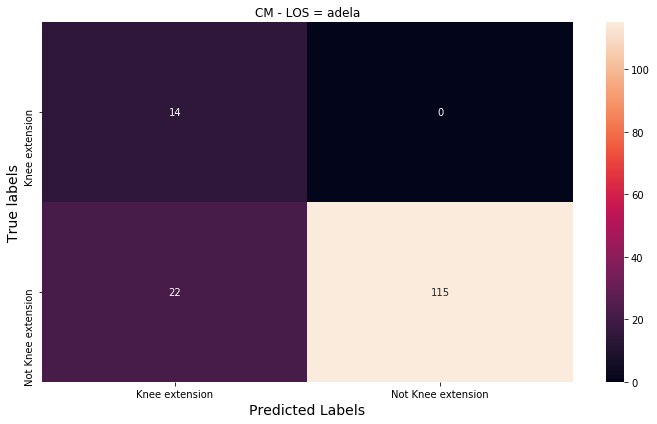

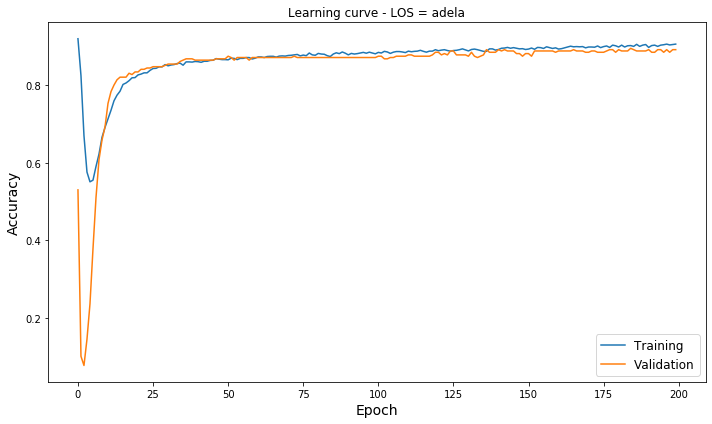

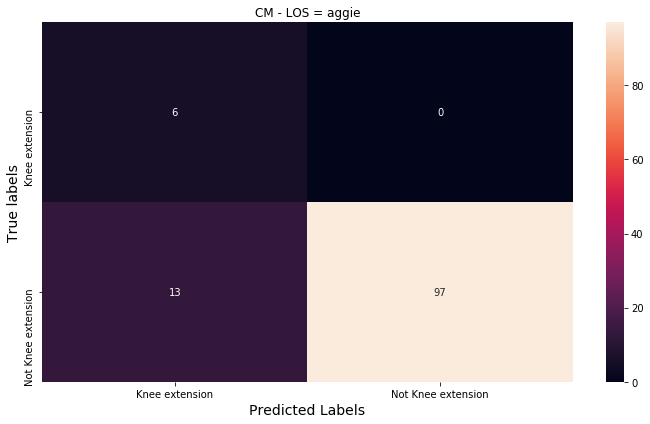

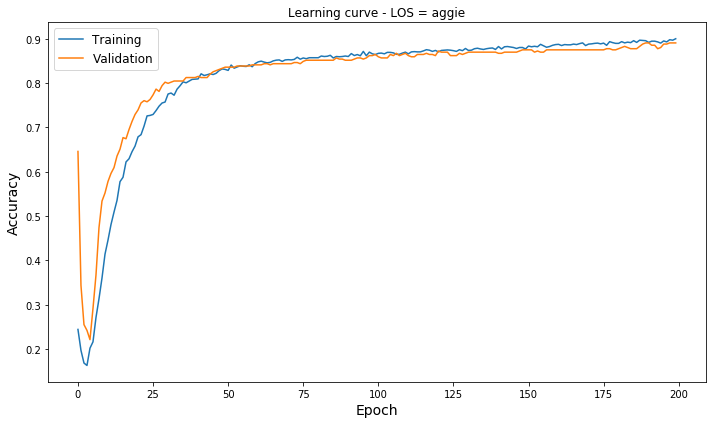

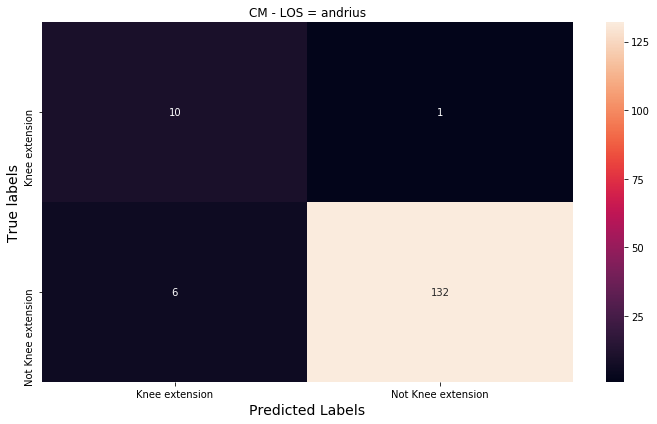

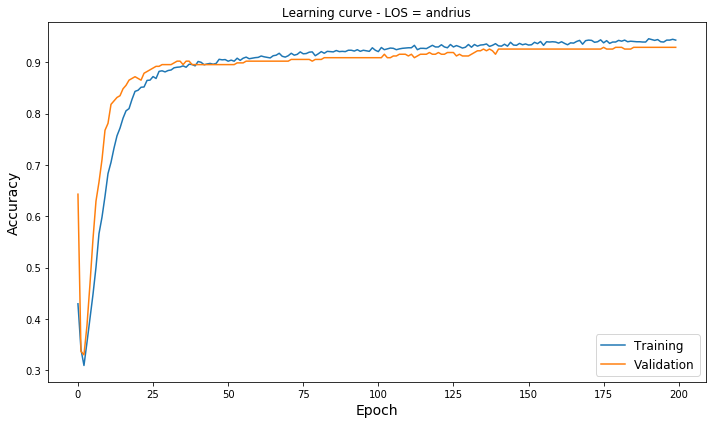

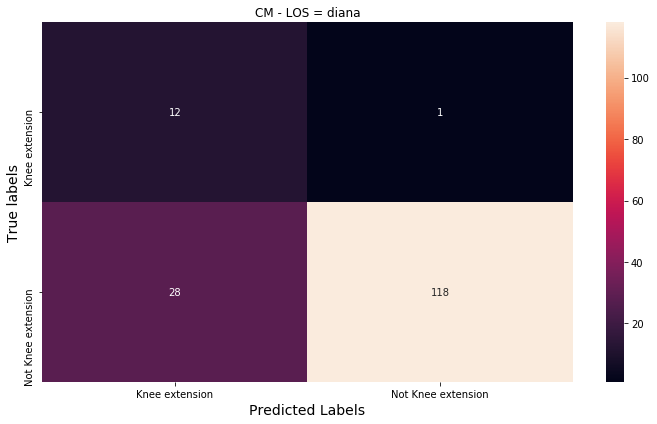

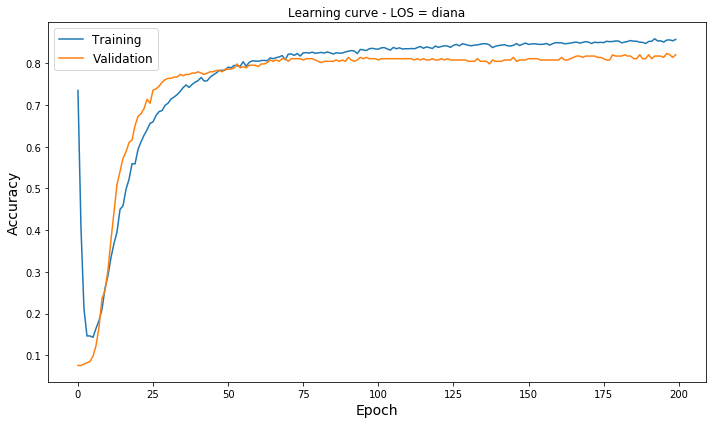

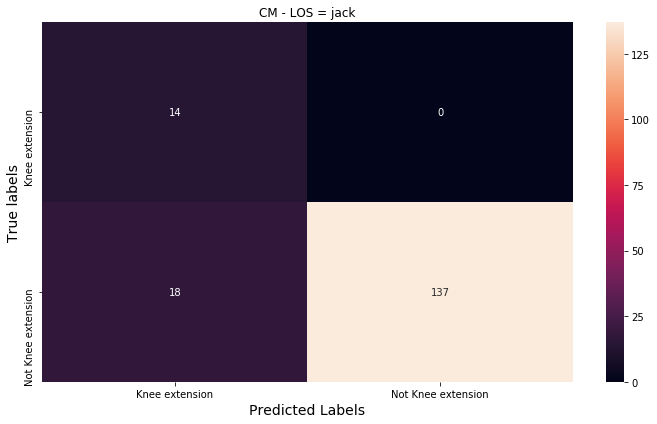

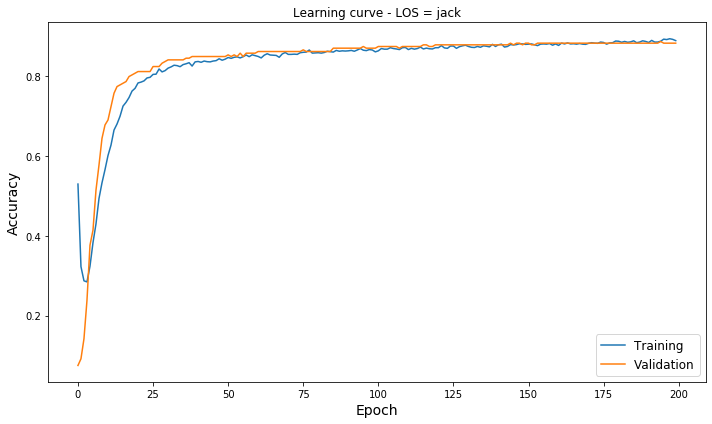

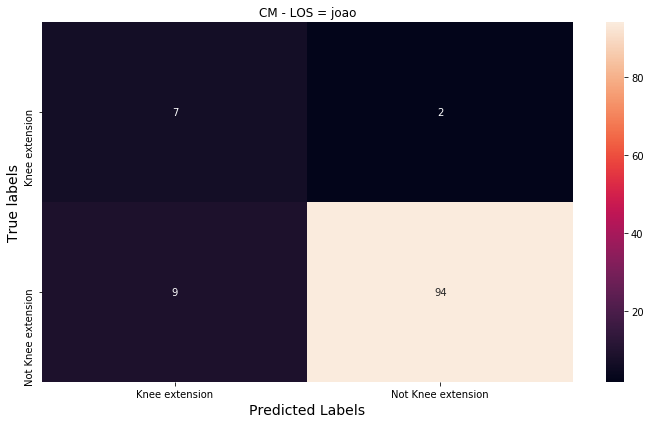

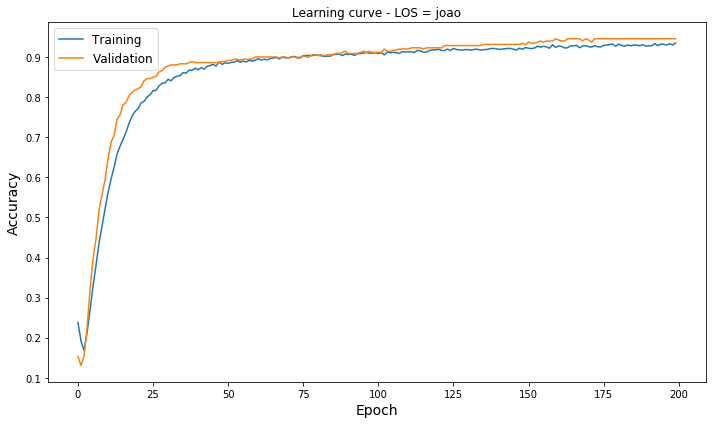

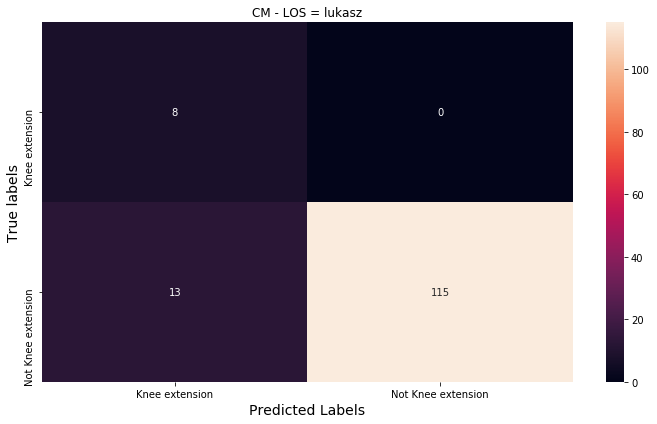

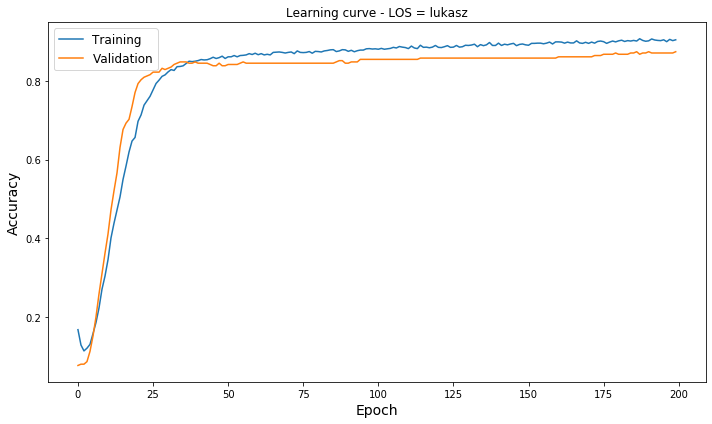

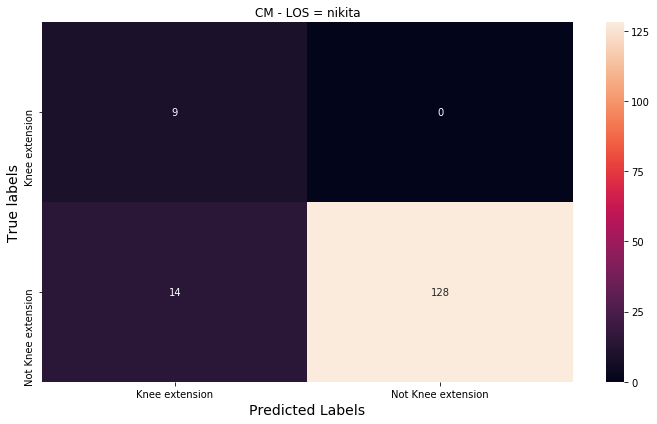

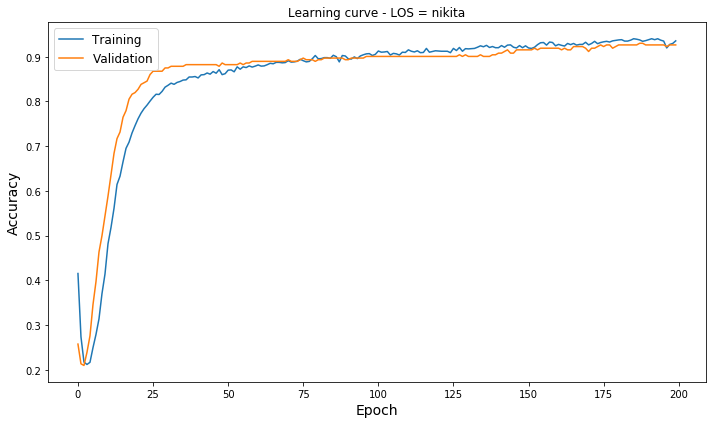

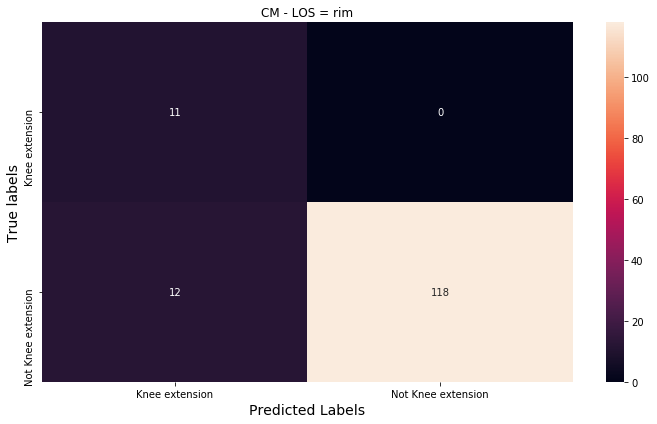

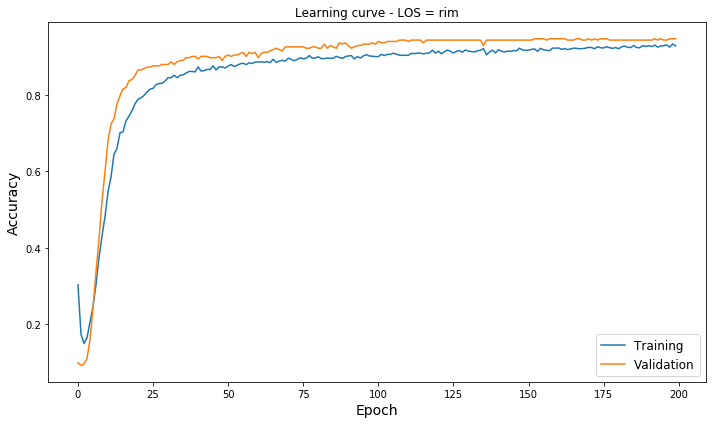

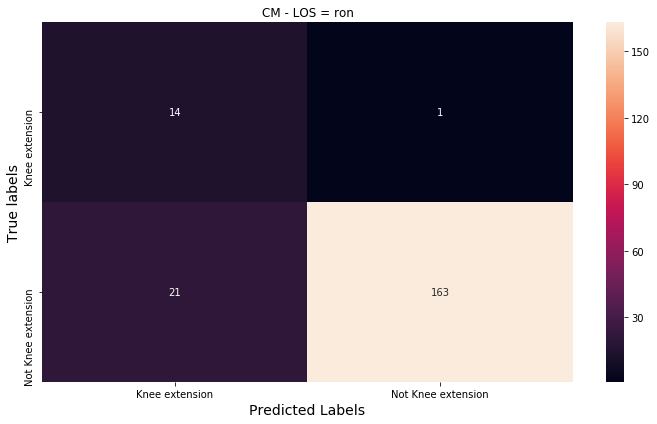

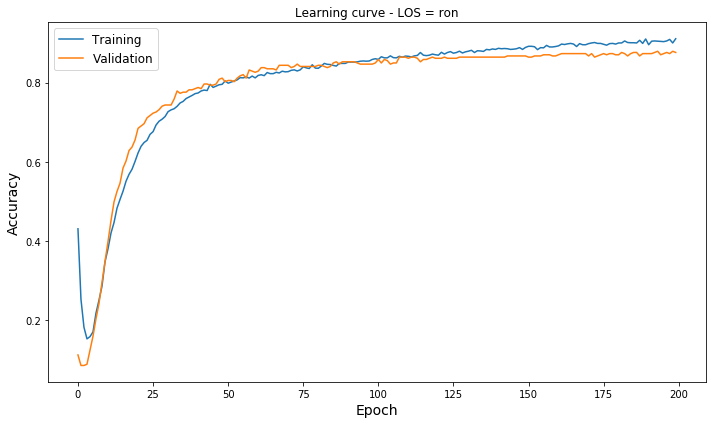

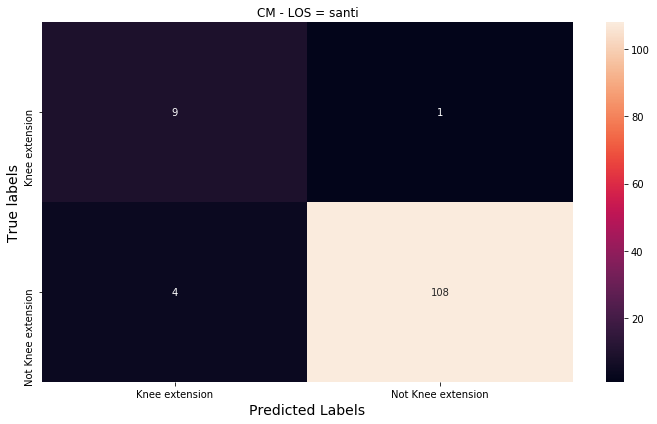

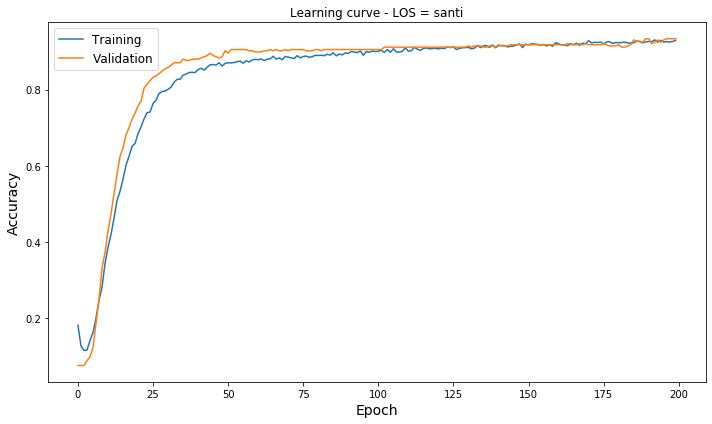

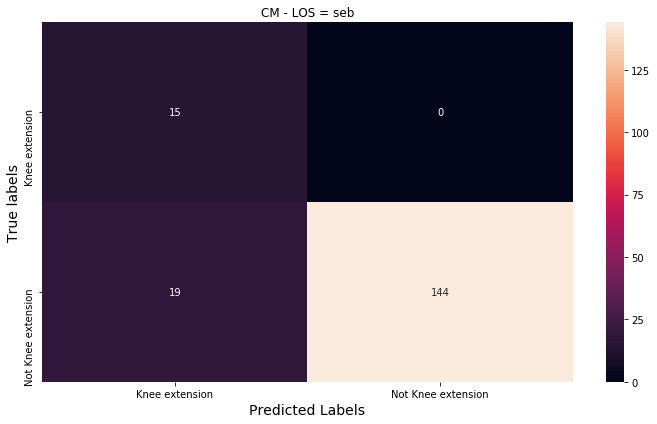

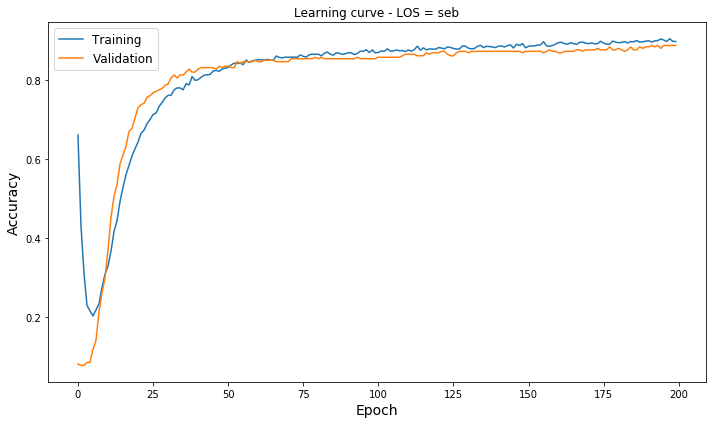

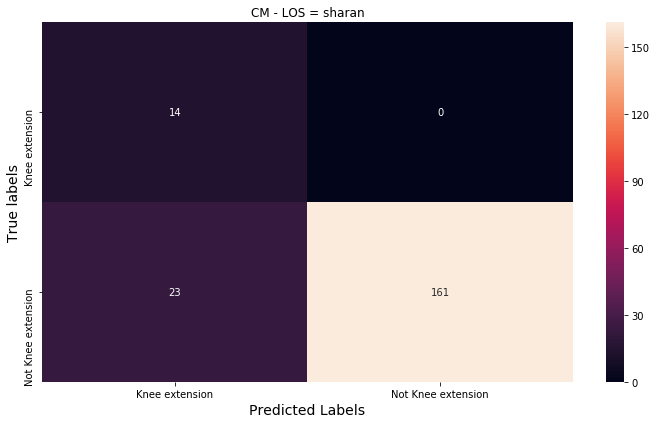

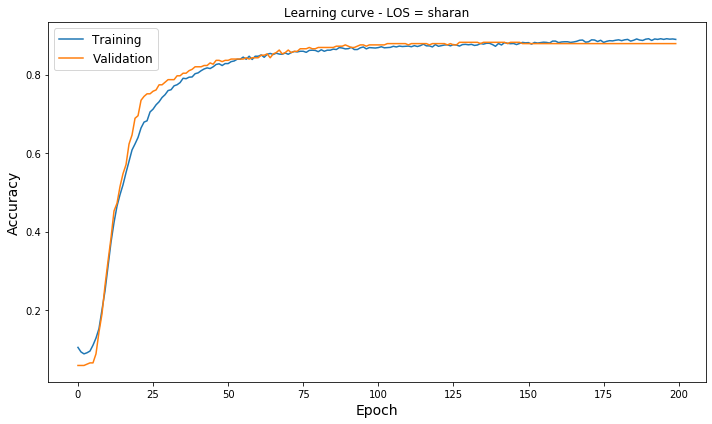

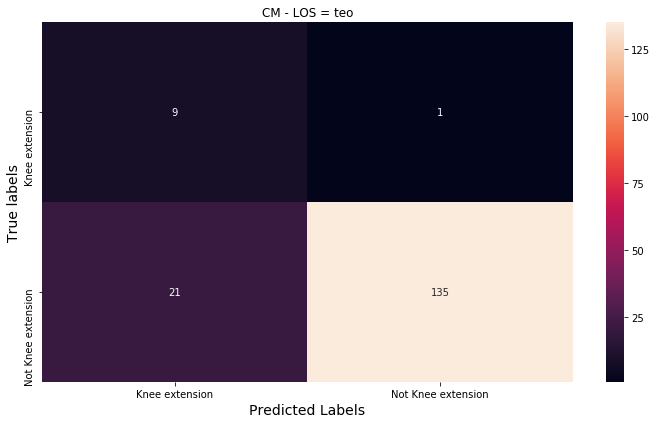

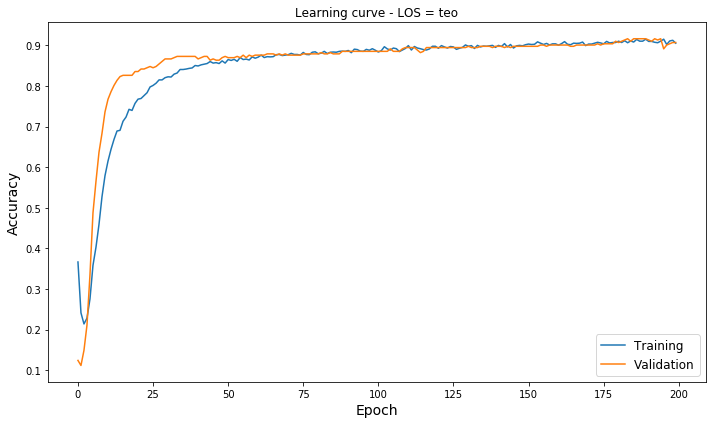

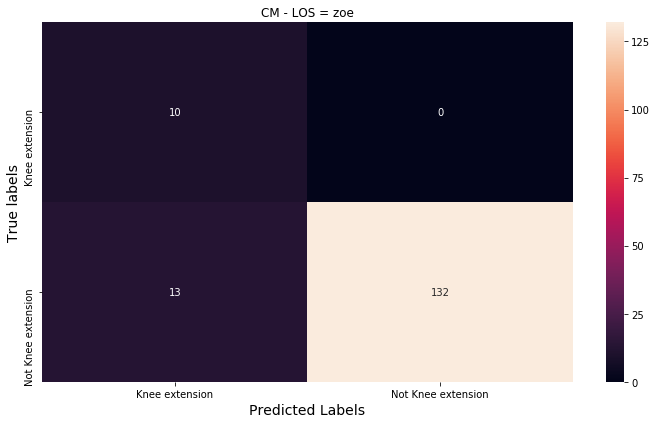

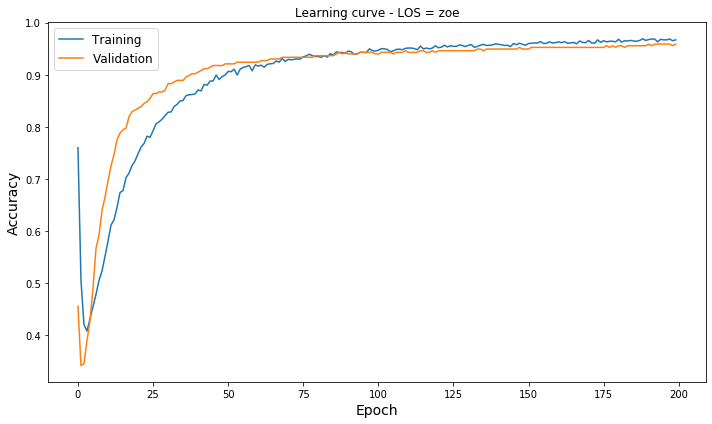

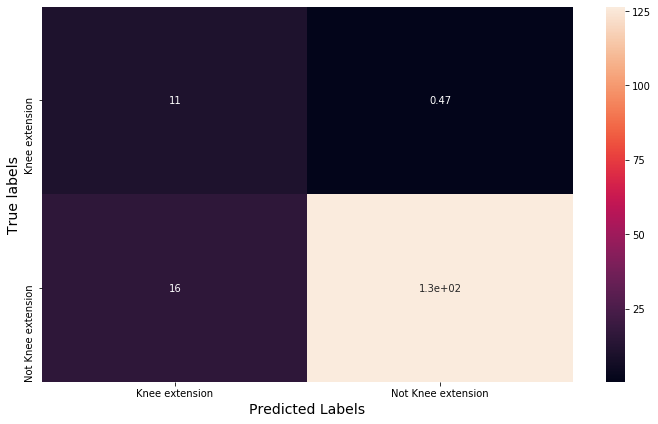

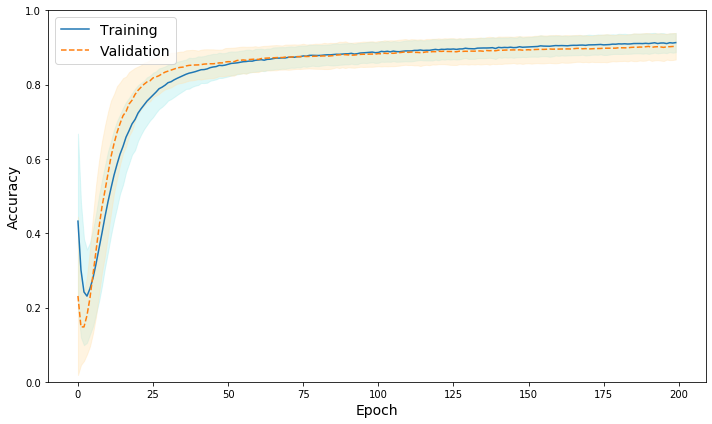

In [13]:
losoxv_one_vs_all(experiment_name, one_vs_all_activity, random_seed, correctness,
                 n_train_subjects, n_validation_subjects,
                 n_time_steps, step, n_features,
                 features, num_filters, kernel_size, activation,
                 lr, batch_size, epochs, downsample_rate, positive_class_weight)